<hr style="height: 1px;">
<i>This notebook was authored by the 8.S50x Course Team, Copyright 2022 MIT All Rights Reserved.</i>
<hr style="height: 1px;">
<br>

<h1>Lesson 21: Monte Carlo I</h1>

<h3>Navigation</h3>

<table style="width:100%">
    <tr>
        <td style="text-align: left; vertical-align: top; font-size: 10pt;"><a href="#section_21_1">L21.1 Monte Carlo Computations</a></td>
        <td style="text-align: left; vertical-align: top; font-size: 10pt;"><a href="#exercises_21_1">L21.1 Exercises</a></td>
    </tr>
    <tr>
        <td style="text-align: left; vertical-align: top; font-size: 10pt;"><a href="#section_21_2">L21.2 Monte Carlo Diffusion</a></td>
        <td style="text-align: left; vertical-align: top; font-size: 10pt;"><a href="#exercises_21_2">L21.2 Exercises</a></td>
    </tr>
    <tr>
        <td style="text-align: left; vertical-align: top; font-size: 10pt;"><a href="#section_21_3">L21.3 Adding Elements of Realism</a></td>
        <td style="text-align: left; vertical-align: top; font-size: 10pt;"><a href="#exercises_21_3">L21.3 Exercises</a></td>
    </tr>
    <tr>
        <td style="text-align: left; vertical-align: top; font-size: 10pt;"><a href="#section_21_4">L21.4 Modelling Physics Observables: Bragg Scattering for Proton Therapy</a></td>
        <td style="text-align: left; vertical-align: top; font-size: 10pt;"><a href="#exercises_21_4">L21.4 Exercises</a></td>
    </tr>
    <tr>
        <td style="text-align: left; vertical-align: top; font-size: 10pt;"><a href="#section_21_5">L21.5 Bragg Scattering for Proton Therapy in Multiple Dimensions</a></td>
        <td style="text-align: left; vertical-align: top; font-size: 10pt;"><a href="#exercises_21_5">L21.5 Exercises</a></td>
    </tr>
</table>

<h3>Learning Objectives</h3>

While, we have been randomly sampling and building toys throughout this class. We have yet to devote a whole lecture to Monte Carlo Simulation. This is the lecture that you have been missing. In the next two lectures, we are going to build a Monte Carlo simulation critical for proton therapy. Then we are going to explore Machine Learning Monte Carlo strategies, and show how some of the biggest advances in Artificial Intelligence are changing the way we simulation scientific data.

<h3>Installing Tools</h3>

Before we do anything, let's make sure we install the tools we need.

In [1]:
!pip install pylandau
!pip install git+https://github.com/SengerM/landaupy

  Cloning https://github.com/SengerM/landaupy to /private/var/folders/4t/mwl83f3x1ls0jvy35v4qzj7c0000gp/T/pip-req-build-2hs7yi7u
  Running command git clone --filter=blob:none --quiet https://github.com/SengerM/landaupy /private/var/folders/4t/mwl83f3x1ls0jvy35v4qzj7c0000gp/T/pip-req-build-2hs7yi7u
  Resolved https://github.com/SengerM/landaupy to commit fad88ce49fee62fa45f1adb34f130b3069df8210
  Preparing metadata (setup.py) ... done


<h3>Importing Libraries</h3>

Before beginning, run the cell below to import the relevant libraries for this notebook.

In [3]:
import imageio
from PIL import Image

import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import csv
import math
from scipy import optimize as opt


<h3>Setting Default Figure Parameters</h3>

The following code cell sets default values for figure parameters.


In [4]:
#>>>RUN: L10.0-runcell02

#set plot resolution
%config InlineBackend.figure_format = 'retina'

#set default figure parameters
plt.rcParams['figure.figsize'] = (9,6)

medium_size = 12
large_size = 15

plt.rc('font', size=medium_size)          # default text sizes
plt.rc('xtick', labelsize=medium_size)    # xtick labels
plt.rc('ytick', labelsize=medium_size)    # ytick labels
plt.rc('legend', fontsize=medium_size)    # legend
plt.rc('axes', titlesize=large_size)      # axes title
plt.rc('axes', labelsize=large_size)      # x and y labels
plt.rc('figure', titlesize=large_size)    # figure title

<a name='section_21_2'></a>
<hr style="height: 1px;">

## <h2 style="border:1px; border-style:solid; padding: 0.25em; color: #FFFFFF; background-color: #90409C">L21.2 Monte Carlo Diffusion</h2>  

| [Top](#section_21_0) | [Previous Section](#section_21_1) | [Exercises](#exercises_21_2) | [Next Section](#section_21_3) |


A good place to start with any Monte Carlo system is a system of random walks. To start with lets consider a simple diffusion model. This works by considering a particle moving along with velocity $\vec{v}$ in a specfic direction. For an distance $\ell$ it will move and scatter. The scatter will cause an angular spread in a random direction, which is given by the velocity of hte particles.

To build a simple model, lets consider just brownian motion, where we simulate each timestep, we give it a random kick corresponding to a collision for a single particle, we can thus write this as randomly choosing a angle every time step, and simulating the particle motion.

For each particle, we will step the particle 100 times and start at 0,0. Furthermore, to show some intelligent thought about parallel computing, we are going to do this simultaneously for 1000 particles at a time. That means we will make an array of 1000 particles and run our simulation simultaneously.

Note, in the last little bit of the code, we will make a rotation matrix that we tile. Then we apply the rotation matrix to our velocities using the following Einstein summation notation.

$$
v^{u}_{j} =  \sum_{i} R^{u}_{\theta,ij} \left(v^{u}_{i}\right) \\
$$


mean distance form center 2.1704650165581914
stdard deviaition in x: 1.7264212996370438 y: 1.731478310992038
velocity 1.2585107739884966


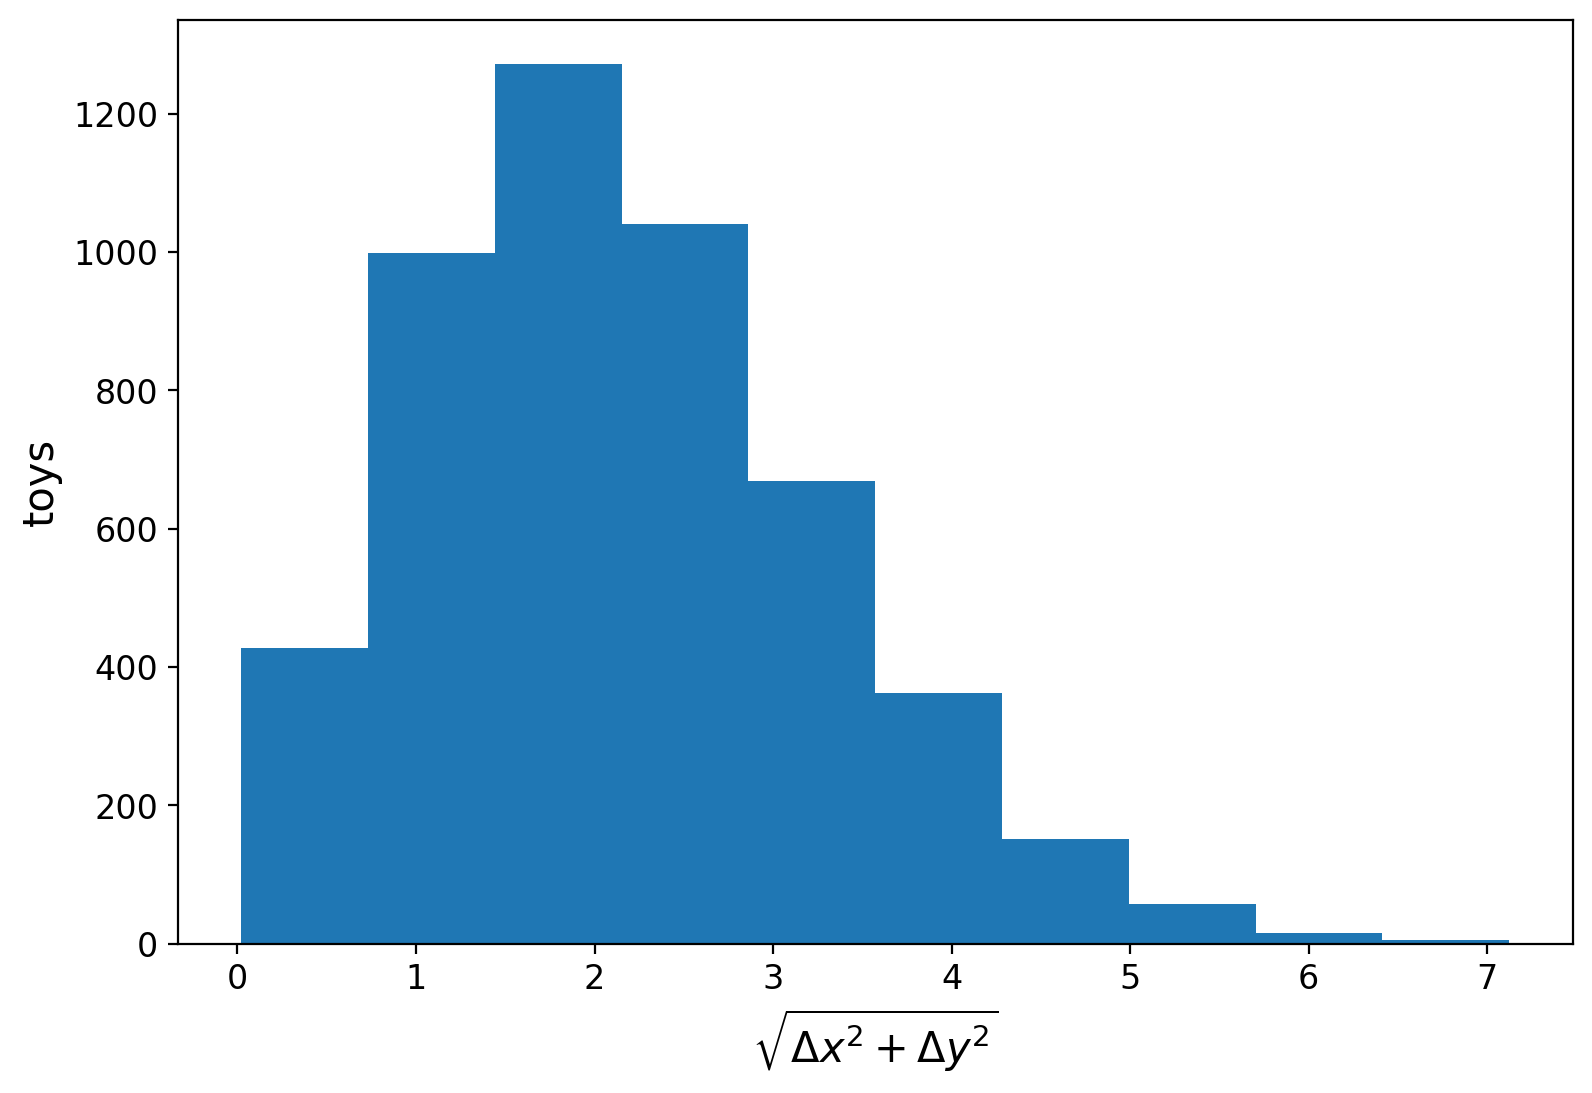

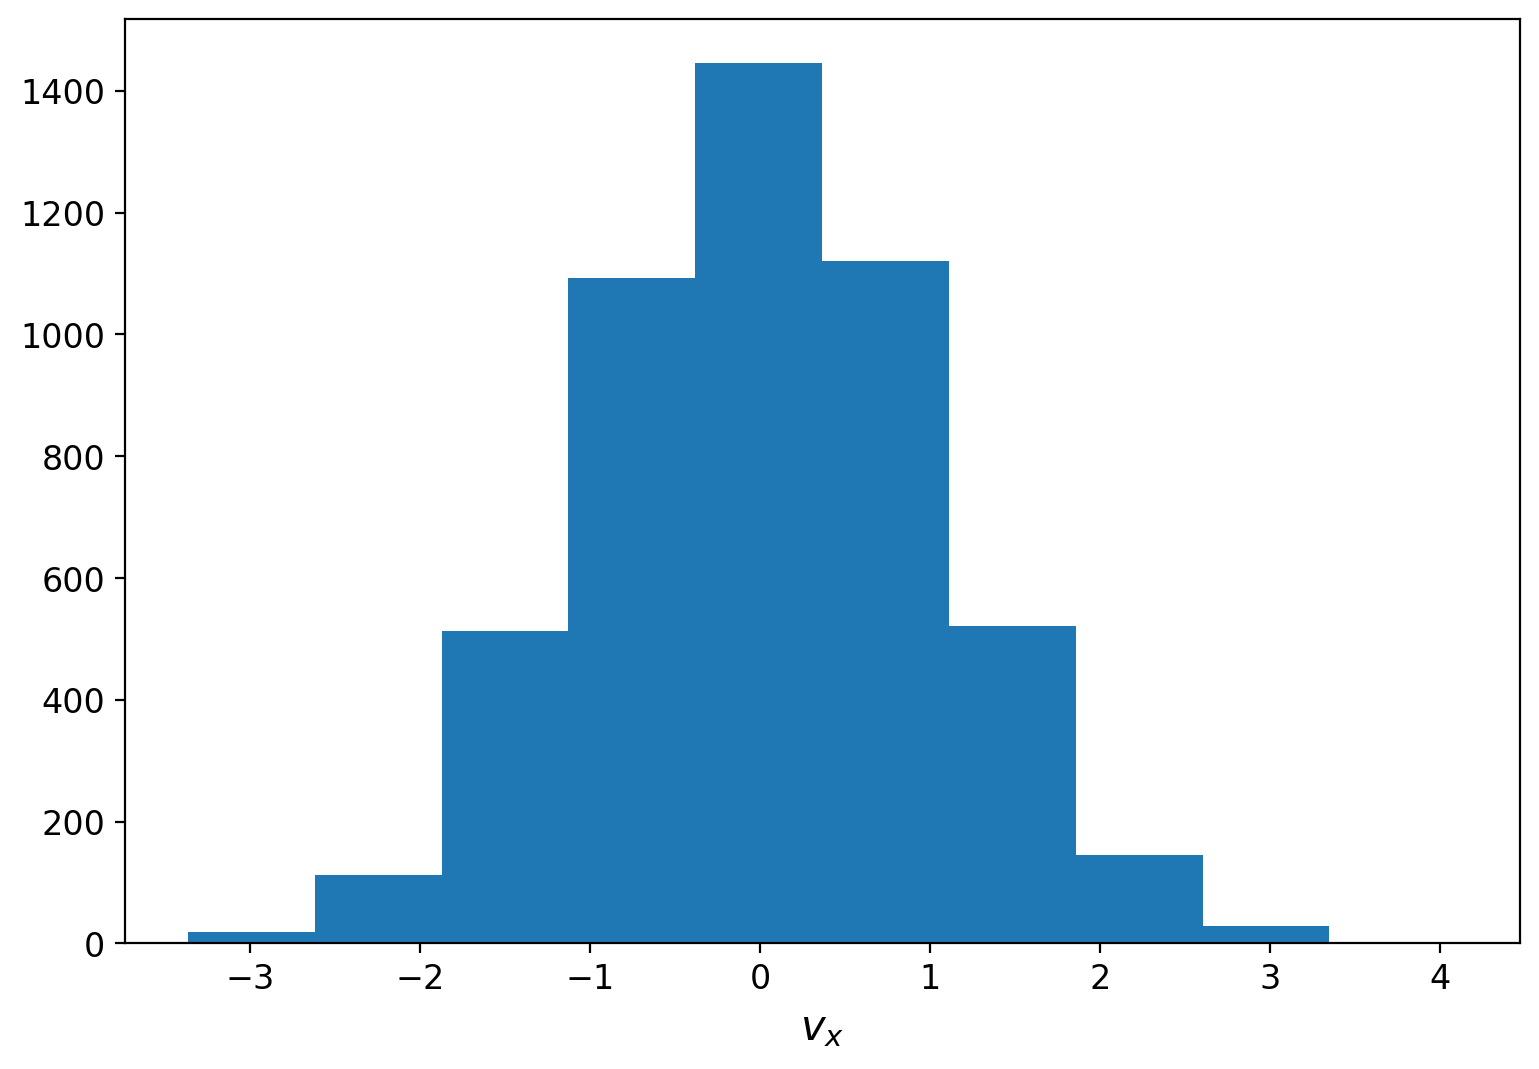

In [39]:
def MCSim(sigmav=1,nsteps=10000,ntoys=5000,dt=0.01,iDump=True):
    partpos=np.zeros((ntoys,2)) #x and y => start the particle at 0
    partvel=np.random.normal(0,1,(ntoys,2)) #lets assume all particles are randomly distributed
    for t0 in range(nsteps):
        partpos += partvel*dt
        #now at each step we will assume the particle collides with another
        opartvel = np.random.normal(0,1,(ntoys,2)) #Sample the "other" particles momentum (not in our simulation
        comvel   = 0.5*(partvel + opartvel) #Now compute the comvoing velocities in the COM frame
        difvel   = 0.5*(partvel - opartvel) #Now compute the collision velocity in the COM frame
        theta = np.random.uniform(0,2.*np.pi,ntoys)#elastic collisiosn in the COM equate to equal energy ad a theta rotation
        R     = np.array(((np.cos(theta), -1*np.sin(theta)), (np.sin(theta), np.cos(theta))))
        #shape things so they are right
        RMat  = np.swapaxes(R,0,2)
        #RMat  = np.reshape((np.tile(R, ntoys)).T,(ntoys,2,2))#make the Rotation Matrix for all toys
        #tmp2=np.matmul(RMat[0],difvel[0])
        tmp=np.einsum('BNi,Bi ->BN', RMat, difvel) #Now rotate the colliding velocitiies over all toys
        partvel = comvel+tmp

    if iDump:
        plt.hist(np.sqrt(partpos[:,0]**2+partpos[:,1]**2))
        plt.xlabel("$\sqrt{\Delta x^2 + \Delta y^2}$")
        plt.ylabel("toys")
        print("mean distance form center",np.mean(np.sqrt(partpos[:,0]**2+partpos[:,1]**2)))
        print("stdard deviaition in x:",np.std(partpos[:,1]),"y:",np.std(partpos[:,0]))
        print("velocity",np.mean(np.sqrt(partvel[:,0]**2+partvel[:,1]**2)))
        plt.show()
        plt.hist(partvel[:,0])
        plt.xlabel("$v_{x}$")
        plt.show()
MCSim()


Now, we can reconcile these numbers with our knowledge of Brownian motion, noting how things diffuse. We can write this, we would like to confirm our measurement of the RMS $x_{\rm rms}=\sqrt{\langle \bar{x}^2 \rangle}$

We can think of this as the width of the distribution after $N$ collisions with a collision length of $\ell$. For a time $t$ and a velocity $v$ the number collisions will be $N=\frac{vt}{\ell}$ or in otherwords

$$
x_{\rm rms} = \sqrt{N}\ell = \sqrt{vt\ell}
$$

Other ways of thinking this are in terms the velocity

$$
\frac{d}{dt}\langle \bar{x}^2 \rangle = 2x\cdot\frac{d \bar{x}}{dt} = 2\langle \bar{x}\cdot\bar{v} \rangle\approx2\langle v^2\rangle t
$$
From Brownian motion (see section 5 [here](https://scholar.harvard.edu/files/schwartz/files/2-diffusion.pdf)). What this means is we can predict the rate of diffusion exactly analytically here and compare.

To that, lets just do some quick computations to check our simulation.

First, the average total velocity in two dimensions can be defined as $\langle\sqrt{v_{x}^2+v_{y}^2}\rangle$ since $v_{x}$ and $v_{y}$ are both gaussian distributions with width $1$, the sum of these distributions is known as a [Rayleigh distribution](https://en.wikipedia.org/wiki/Rayleigh_distribution) ($f(x,\sigma)$), which is  just a $\chi^{2}_{2}$ distribution of 2 degrees of freedom with an additional scale term.  

$$
\langle\sqrt{v_{x}^2+v_{y}^2}\rangle = \langle f(x,\sigma) \rangle = \sigma_{v_{i}}\sqrt{\frac{\pi}{2}}
$$

From the above, we can immediately calculate the average RMS of $x$ for a single collision noting that our simulation forces the length to a collision as $\ell=2vdt$ since both particles are moving at each other

$$
\langle \ell \rangle =  2 v dt \\
x_{\rm rms} = \sqrt{N}\ell = \sqrt{v N dt\ell}=\sqrt{2 v^2 N dt^2}=\sqrt{2 \langle v^2 \rangle N }dt\\
x_{\rm rms} = \sqrt{N}\ell= \sqrt{N}\sqrt{2\langle v^2\rangle} dt = \sqrt{\sigma_{v_{i}}N2\frac{\pi}{2}}dt
$$


For $\sigma_{v_{i}}=1$ as in this case, we have then that the

$$
x_{\rm rms} = \sqrt{2\sigma^{2}_{v_{i}}\frac{\pi}{2}}\sqrt{N}dt
$$

We can compute the total distance noting again the Rayleigh distribuion

$$
\langle r \rangle=\langle \sqrt{x_{\rm rms}^2 + y_{\rm rms}^2} \rangle = \sqrt{\frac{\pi}{2}} x_{\rm rms}
$$

In [74]:
print("<v> Rayleigh",np.sqrt(np.pi/2))
print("<x_rms> Rayleigh dt sqrt(N)",np.sqrt(np.pi/2)*np.sqrt(2)*0.01*np.sqrt(10000))
print("<r> Expected mean distance form center: ",np.sqrt(np.pi/2)*np.sqrt(2)*0.01*np.sqrt(10000)*np.sqrt(np.pi/2))
#

<v> Rayleigh 1.2533141373155001
<x_rms> Rayleigh dt sqrt(N) 1.772453850905516
<r> Expected mean distance form center:  2.221441469079183


This agrees well with our standard deviation of the position $x$ above which is $x_{rms}$=1.7

<a name='exercises_21_2'></a>     

| [Top](#section_21_0) | [Restart Section](#section_21_2) | [Next Section](#section_21_3) |


### <span style="border:3px; border-style:solid; padding: 0.15em; border-color: #90409C; color: #90409C;">Ex-21.2.1</span>

Show that the velocity distribution remains the same as we run our simulation over time?

In [30]:
def MCSim(sigmav=1,nsteps=10000,ntoys=5000,dt=0.01,iDump=True):
    partpos=np.zeros((ntoys,2)) #x and y
    partvel=np.random.normal(0,1,(ntoys,2))
    print("velocity Before:",np.mean(np.sqrt(partvel[:,0]**2+partvel[:,1]**2)))
    for t0 in range(nsteps):
        opartvel = np.random.normal(0,1,(ntoys,2))
        partpos += partvel*dt
        comvel   = 0.5*(partvel + opartvel)
        difvel   = 0.5*(partvel - opartvel)
        theta = np.random.uniform(0,2.*np.pi,ntoys)
        R     = np.array(((np.cos(theta), -1*np.sin(theta)), (np.sin(theta), np.cos(theta))))
        RMat  = np.swapaxes(R,0,2)
        tmp=np.einsum('BNi,Bi ->BN', RMat, difvel)
        partvel = comvel+tmp

    print("velocity After:",np.mean(np.sqrt(partvel[:,0]**2+partvel[:,1]**2)))
MCSim()


velocity Before: 1.247020776319064
velocity After: 1.2571558916757966


<div style="border:1.5px; border-style:solid; padding: 0.5em; border-color: #90409C; color: #90409C;">

**SOLUTION:**

<pre>
No change
</pre>
        
**EXPLANATION:**
    
This is one of the remarkable things about these systems is that at high level, we can observe conserved quantities with these simulations even though we are only looking at the motion of a few particles at a time. Very amazing.
    
</div>

<a name='section_21_3'></a>
<hr style="height: 1px;">

## <h2 style="border:1px; border-style:solid; padding: 0.25em; color: #FFFFFF; background-color: #90409C">L21.3 Adding Elements of Realism</h2>  

| [Top](#section_21_0) | [Previous Section](#section_21_2) | [Exercises](#exercises_21_3) | [Next Section](#section_21_4) |

Now, given our Monte Carlo simulation, we can start to add element of realism, this will slow our monte carlo. Lets put a wall in our particle simulation and if the particle hits the wall, we need to invert the velocity. Which means we just flip our particle velocity as we go along.

Let's go ahead and implement this. For this all, what we need to do is if the x-position of our sample is $>$ the wall value (say $x=2$) then we flip the x-velocity and not simulate an elastic collision. For our setup, its relatively easy to do. 

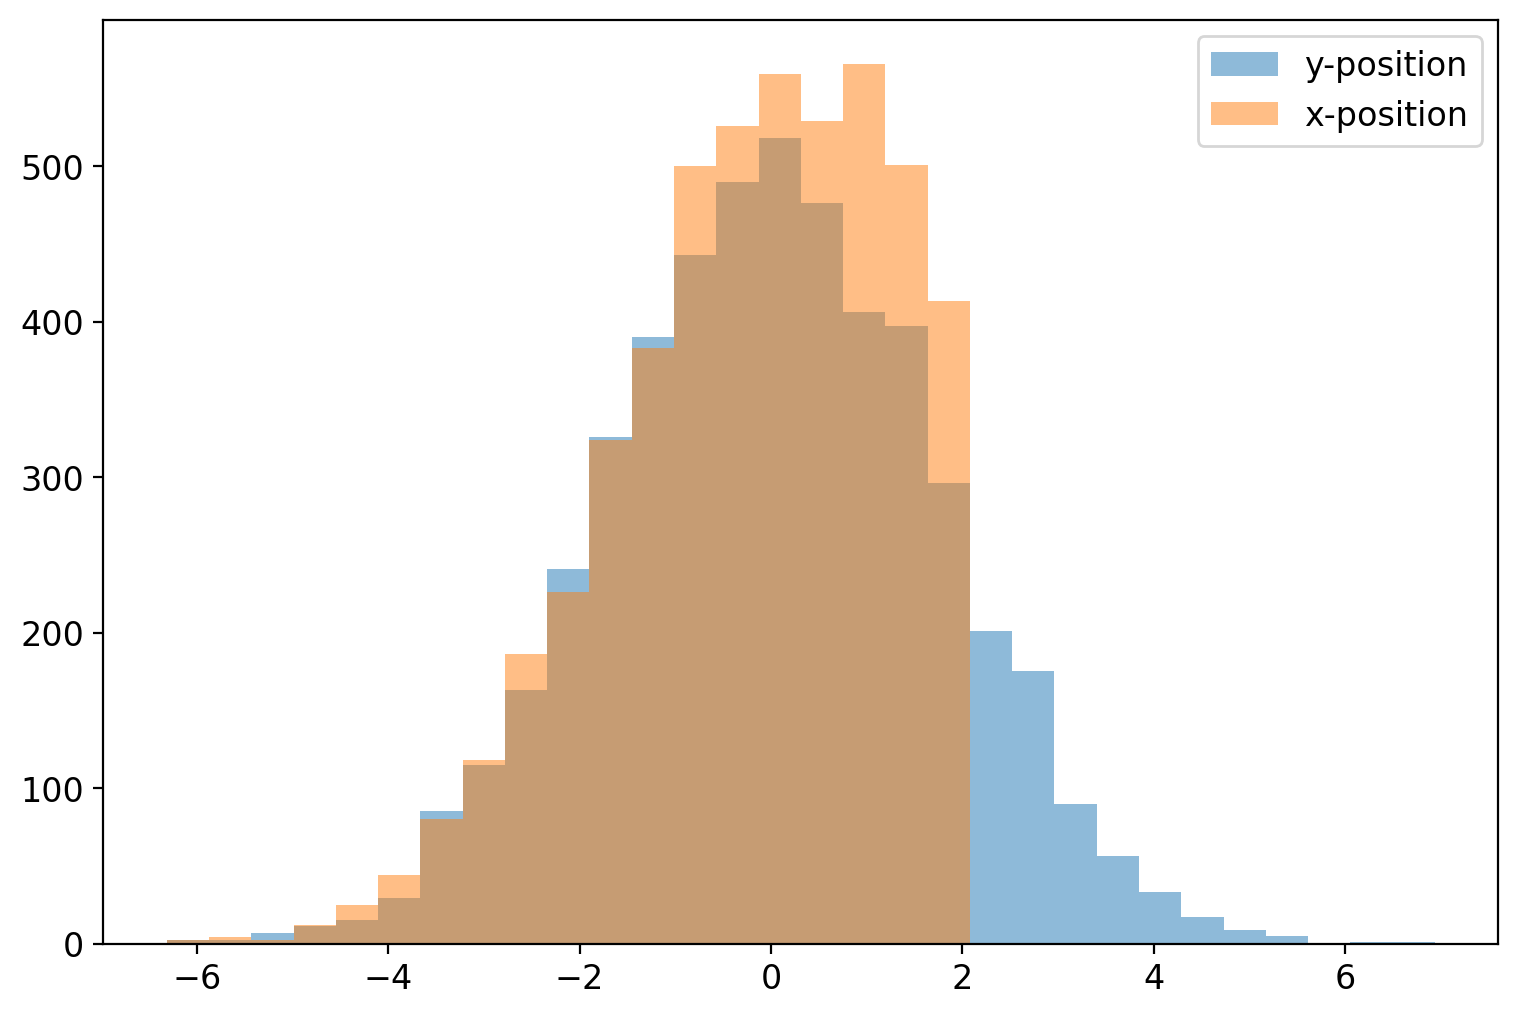

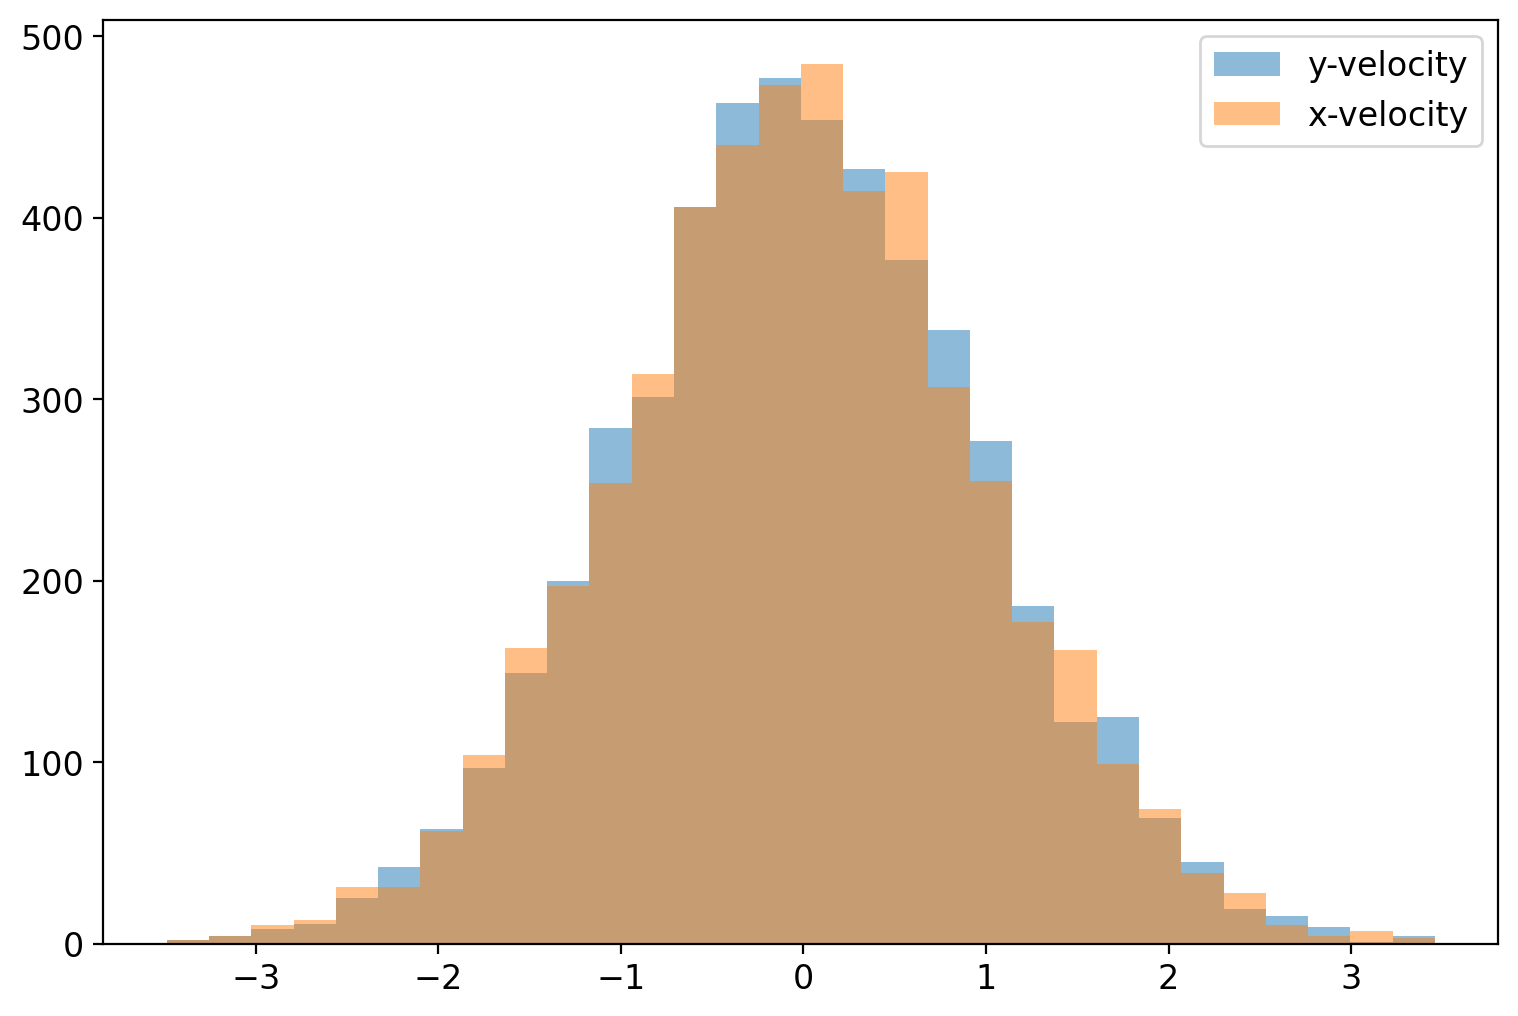

In [75]:
def MCSim(sigmav=1,nsteps=10000,ntoys=5000,dt=0.01,iDump=True):
    partpos=np.zeros((ntoys,2)) #x and y
    partvel=np.random.normal(0,1,(ntoys,2))
    for t0 in range(nsteps):
        opartvel = np.random.normal(0,1,(ntoys,2))
        partpos += partvel*dt
        comvel   = 0.5*(partvel + opartvel)
        difvel   = 0.5*(partvel - opartvel)
        theta = np.random.uniform(0,2.*np.pi,ntoys)
        R     = np.array(((np.cos(theta), -1*np.sin(theta)), (np.sin(theta), np.cos(theta))))
        RMat  = np.swapaxes(R,0,2)
        #tmp2=np.matmul(RMat[0],difvel[0])
        tmp=np.einsum('BNi,Bi ->BN', RMat, difvel)
        #Now, lets add our velocity if its not at the well
        partvel[partpos[:,0] < 2] = comvel[partpos[:,0] < 2]+tmp[partpos[:,0] < 2]
        #And lets flip it if it is at the wall
        partvel[partpos[:,0] > 2] = -partvel[partpos[:,0] > 2]
    if iDump:
        _,bins,_=plt.hist(partpos[:,1],bins=30,alpha=0.5,label='y-position')
        plt.hist(partpos[:,0],bins=bins,alpha=0.5,label='x-position')
        plt.legend()
        plt.show()
        _,bins,_=plt.hist(partvel[:,1],bins=30,alpha=0.5,label='y-velocity')
        plt.hist(partvel[:,0],bins=bins,alpha=0.5,label='x-velocity')
        plt.legend()
        plt.show()
MCSim()

Now, we could do some thing even more complicated by imagining that we have a tube and we are looking at the Brownian motion within the tube. Particles, which hit the tube will then have their velocity reflected in the opposite direction. In other words, we have

$$
v_{i} = - v_{i} \forall i {\rm~ where~} r_{i}=\sqrt{x_{i}^2+y_{i}^2} > r_{\rm tube}
$$

or reflecting particles that try to escape the tube. Let's make a tube of radius $2$, lets go ahead and do it!

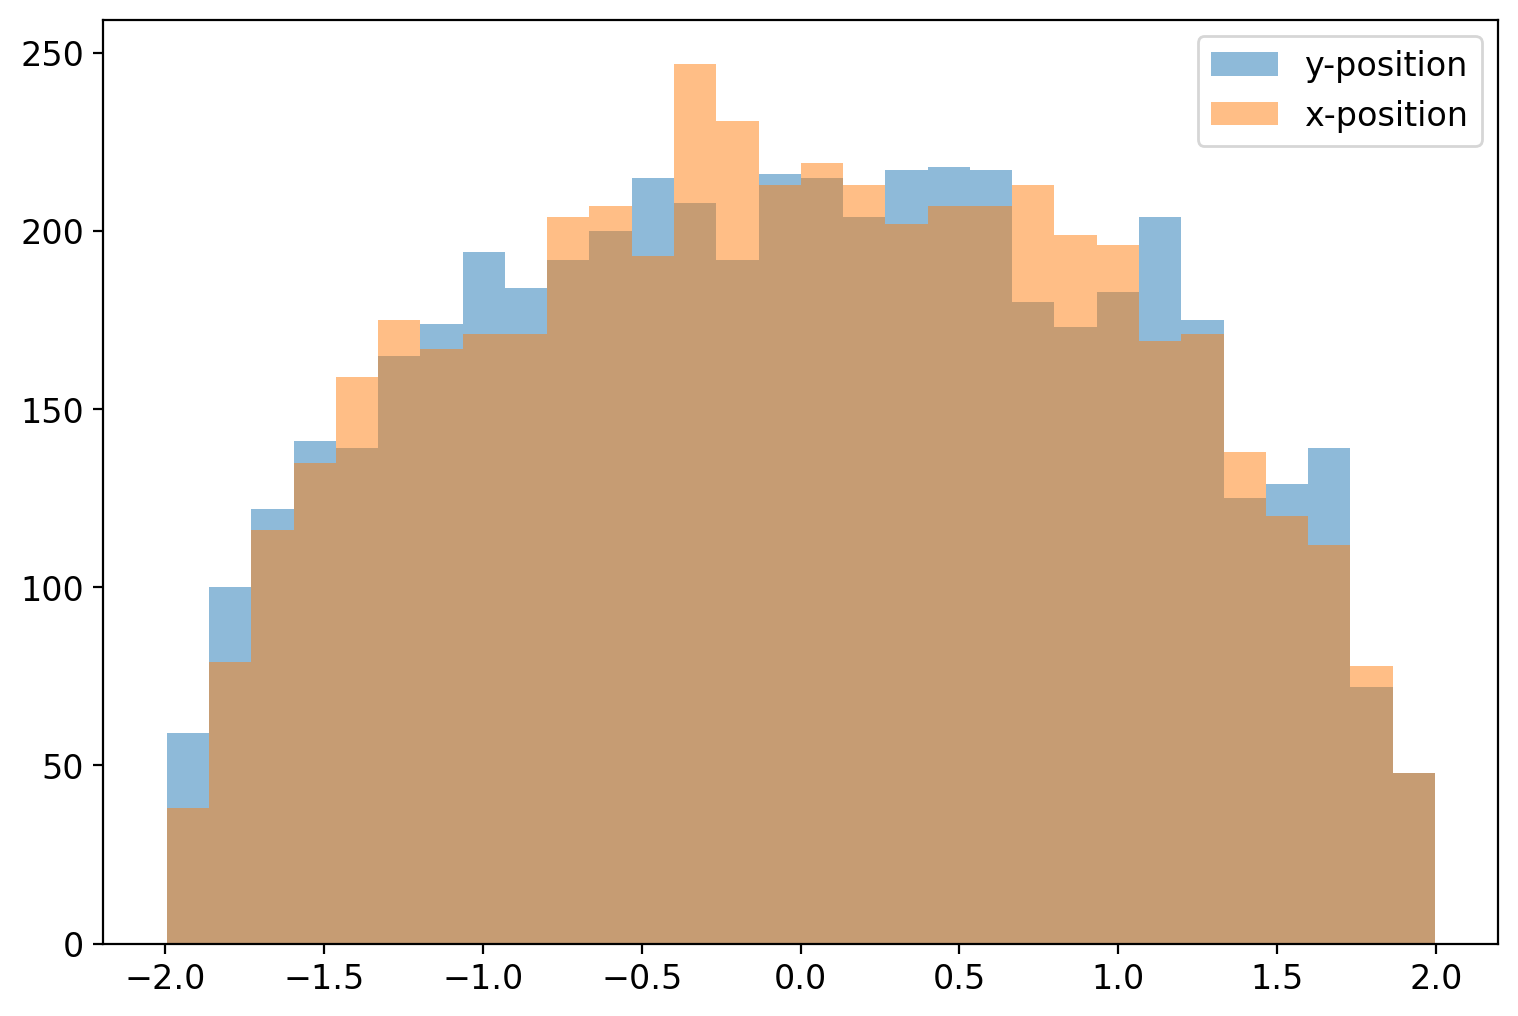

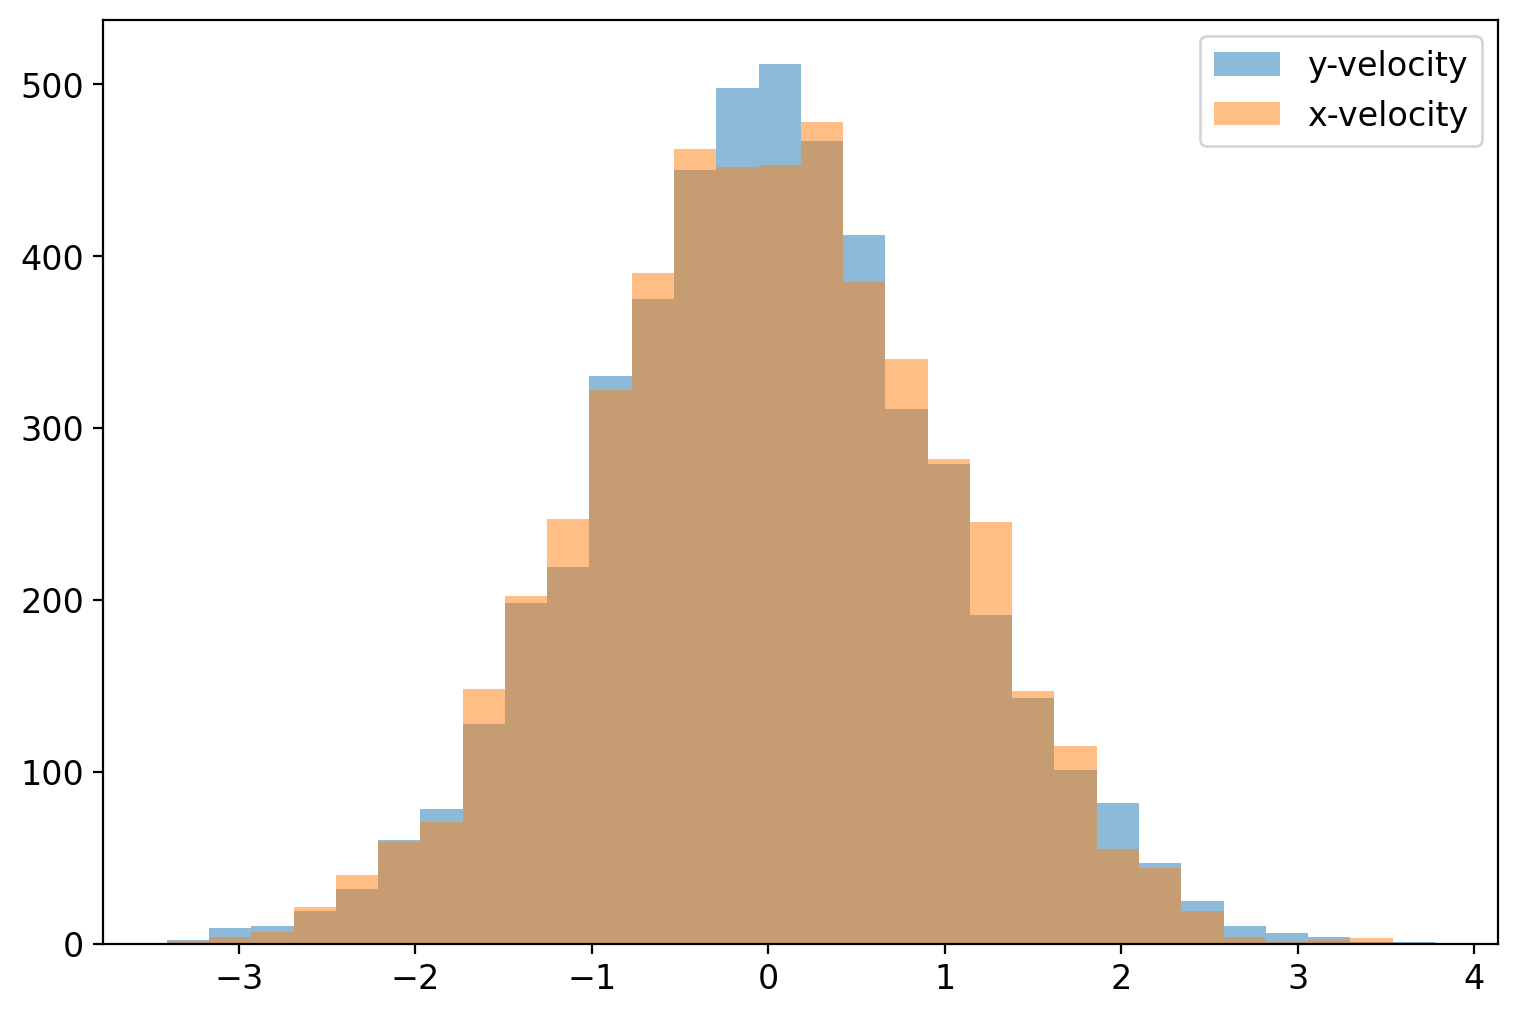

In [76]:
def MCSim(sigmav=1,nsteps=10000,ntoys=5000,dt=0.01,iDump=True):
    partpos=np.zeros((ntoys,2)) #x and y
    partvel=np.random.normal(0,sigmav,(ntoys,2))
    for t0 in range(nsteps):
        opartvel = np.random.normal(0,sigmav,(ntoys,2))
        partpos += partvel*dt
        comvel   = 0.5*(partvel + opartvel)
        difvel   = 0.5*(partvel - opartvel)
        theta = np.random.uniform(0,2.*np.pi,ntoys)
        R     = np.array(((np.cos(theta), -1*np.sin(theta)), (np.sin(theta), np.cos(theta))))
        RMat  = np.swapaxes(R,0,2)
        #tmp2=np.matmul(RMat[0],difvel[0])
        tmp=np.einsum('BNi,Bi ->BN', RMat, difvel)
        #Now define inside the tube
        intube  = partpos[:,0]**2+partpos[:,1]**2 < 4
        partvel[intube]  = comvel[intube]+tmp[intube]
        partvel[~intube] = -partvel[~intube]
    if iDump:
        _,bins,_=plt.hist(partpos[:,1],bins=30,alpha=0.5,label='y-position')
        plt.hist(partpos[:,0],bins=bins,alpha=0.5,label='x-position')
        plt.legend()
        plt.show()
        _,bins,_=plt.hist(partvel[:,1],bins=30,alpha=0.5,label='y-velocity')
        plt.hist(partvel[:,0],bins=bins,alpha=0.5,label='x-velocity')
        plt.legend()
        plt.show()
MCSim()

We can quickly do many more complicated things, the nice thing is that all of this really just needs us to program it in. Its important also here, to note that we are taking advantage of the numpy scheme to parallelize everything. This allows us to simulate 1000s of particles at the same time, and makes everything nice and fast.

<a name='exercises_21_3'></a>     

| [Top](#section_21_0) | [Restart Section](#section_21_3) | [Next Section](#section_21_4) |


### <span style="border:3px; border-style:solid; padding: 0.15em; border-color: #90409C; color: #90409C;">Ex-21.3.1</span>

How does the distribution of the particles change if we increase the velocity spread of the particles?

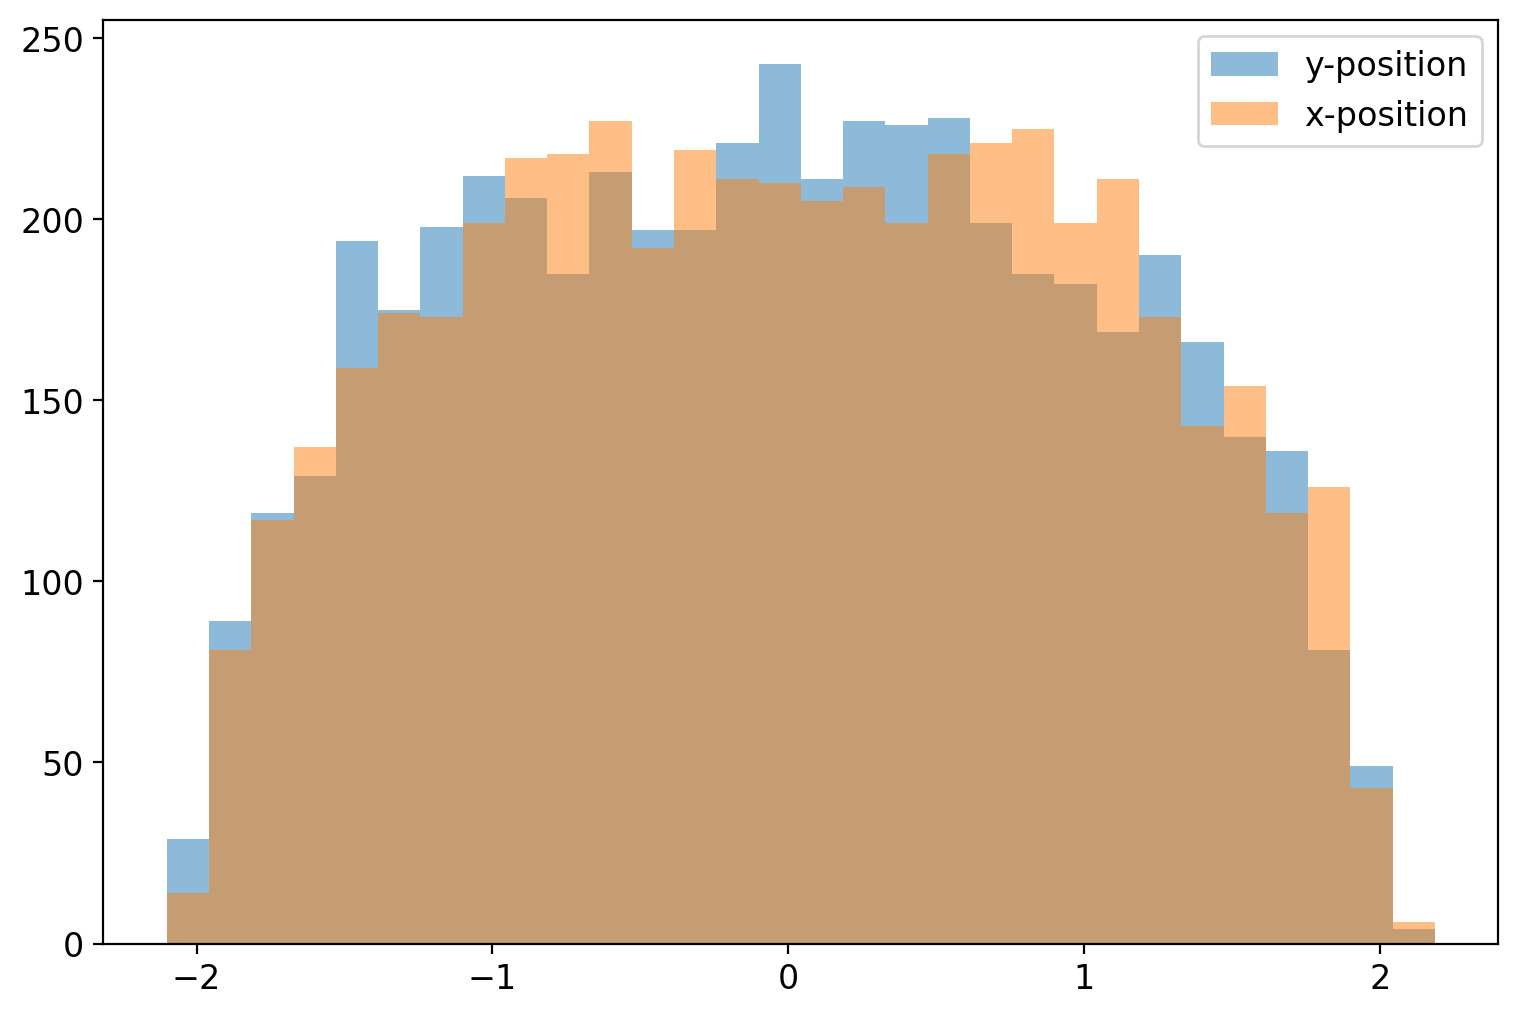

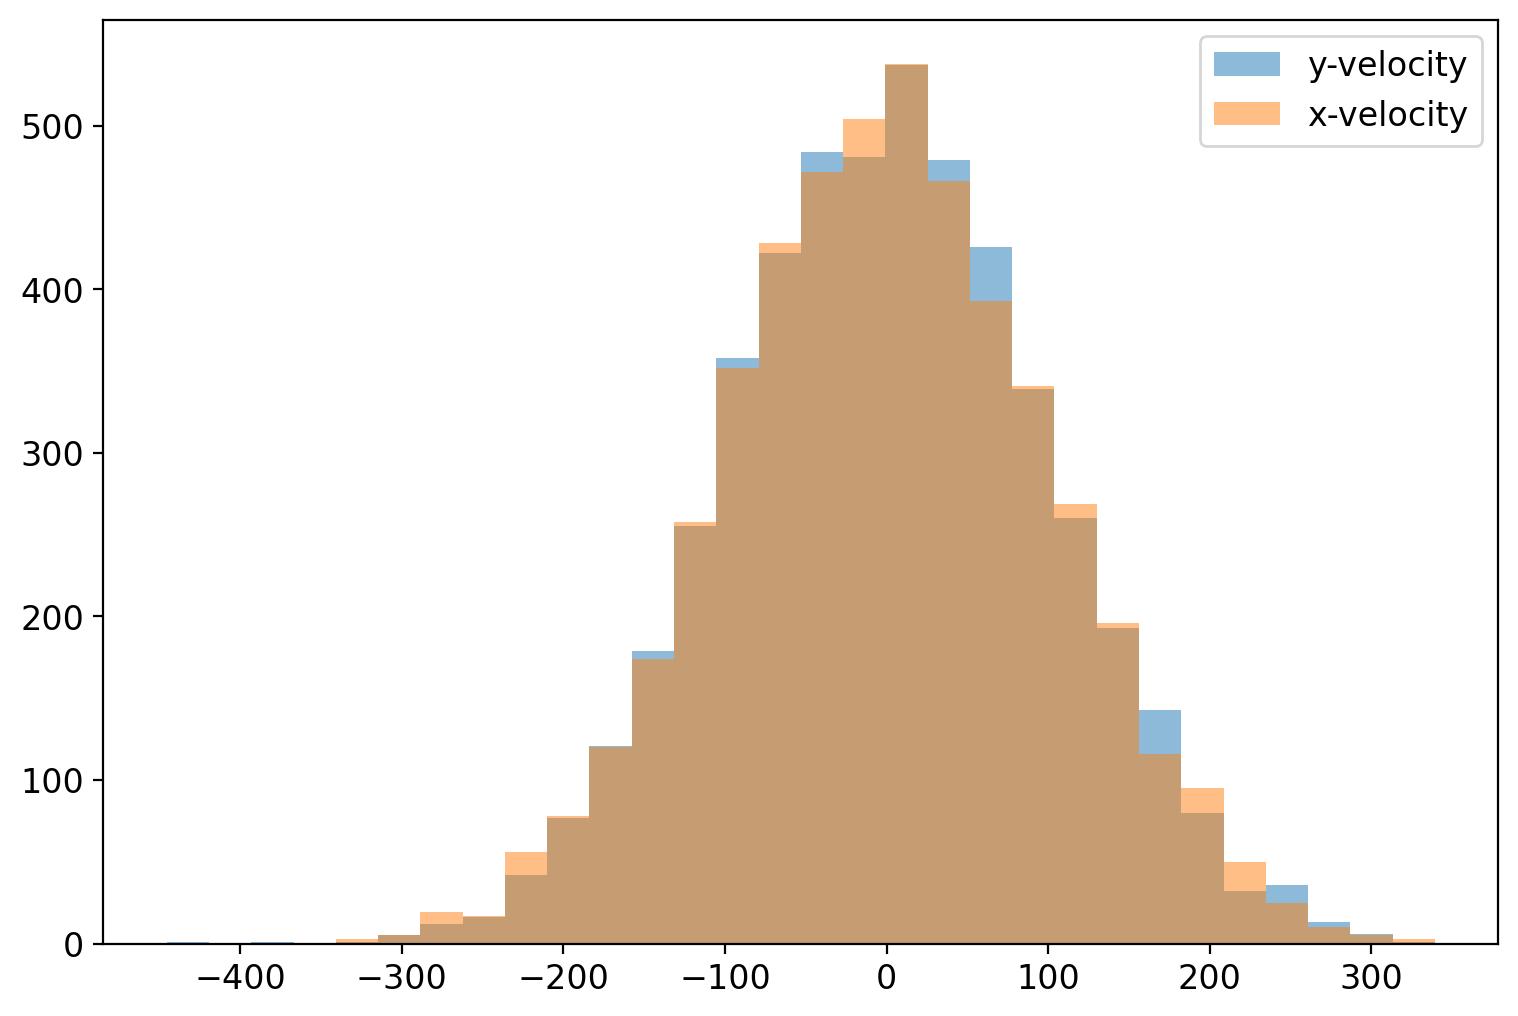

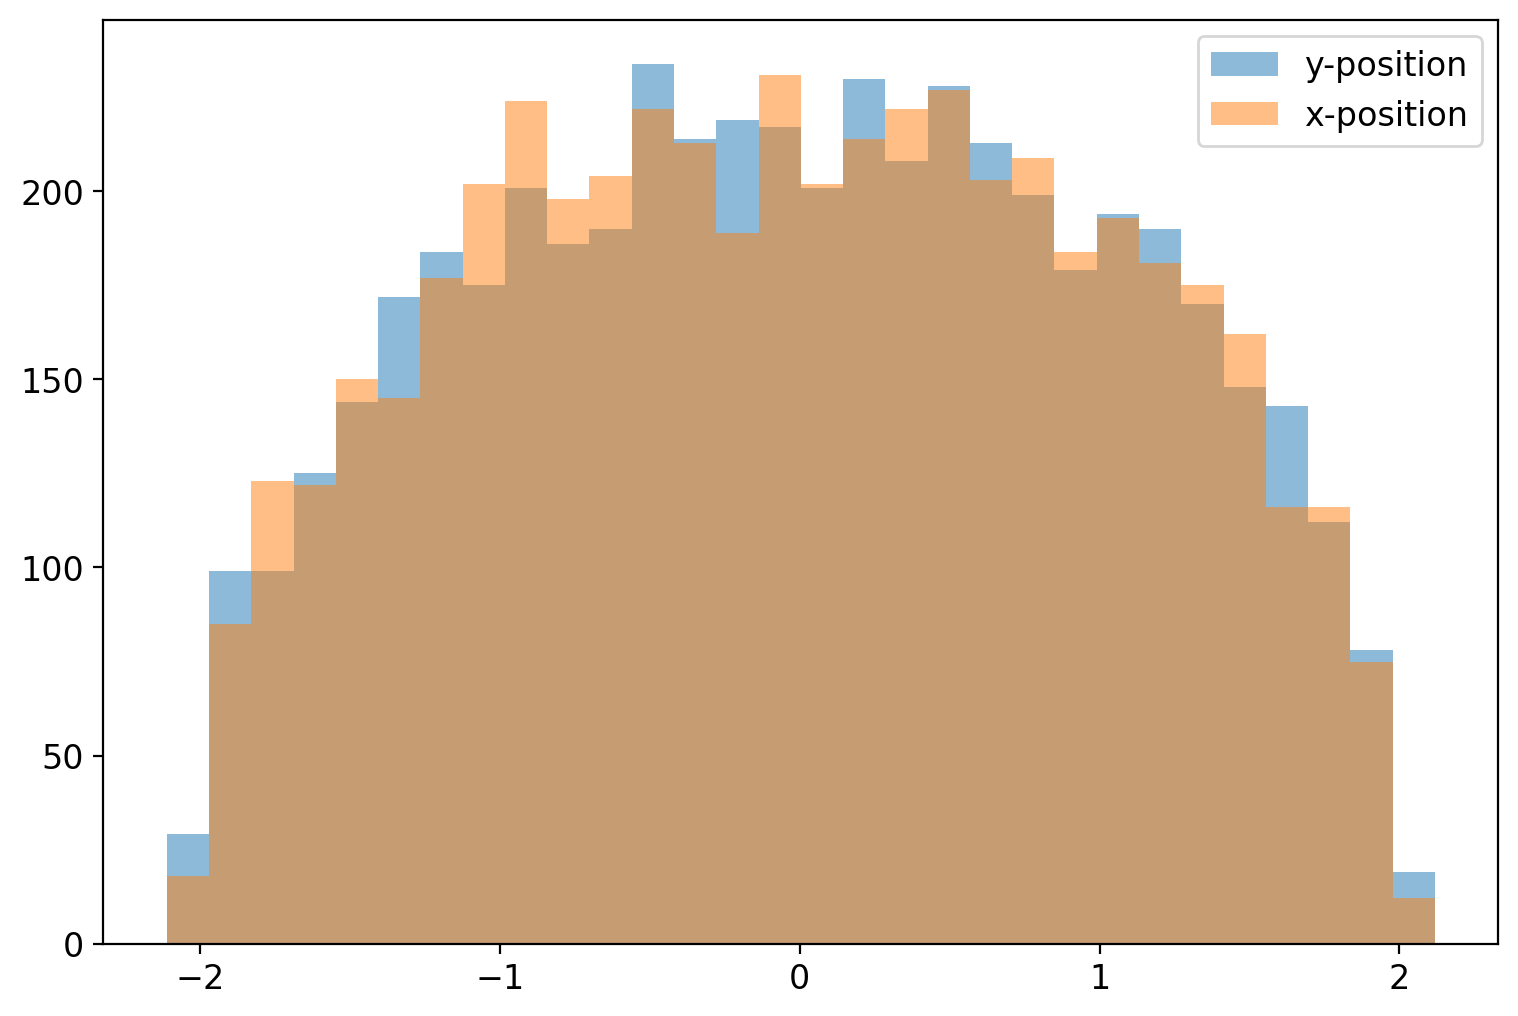

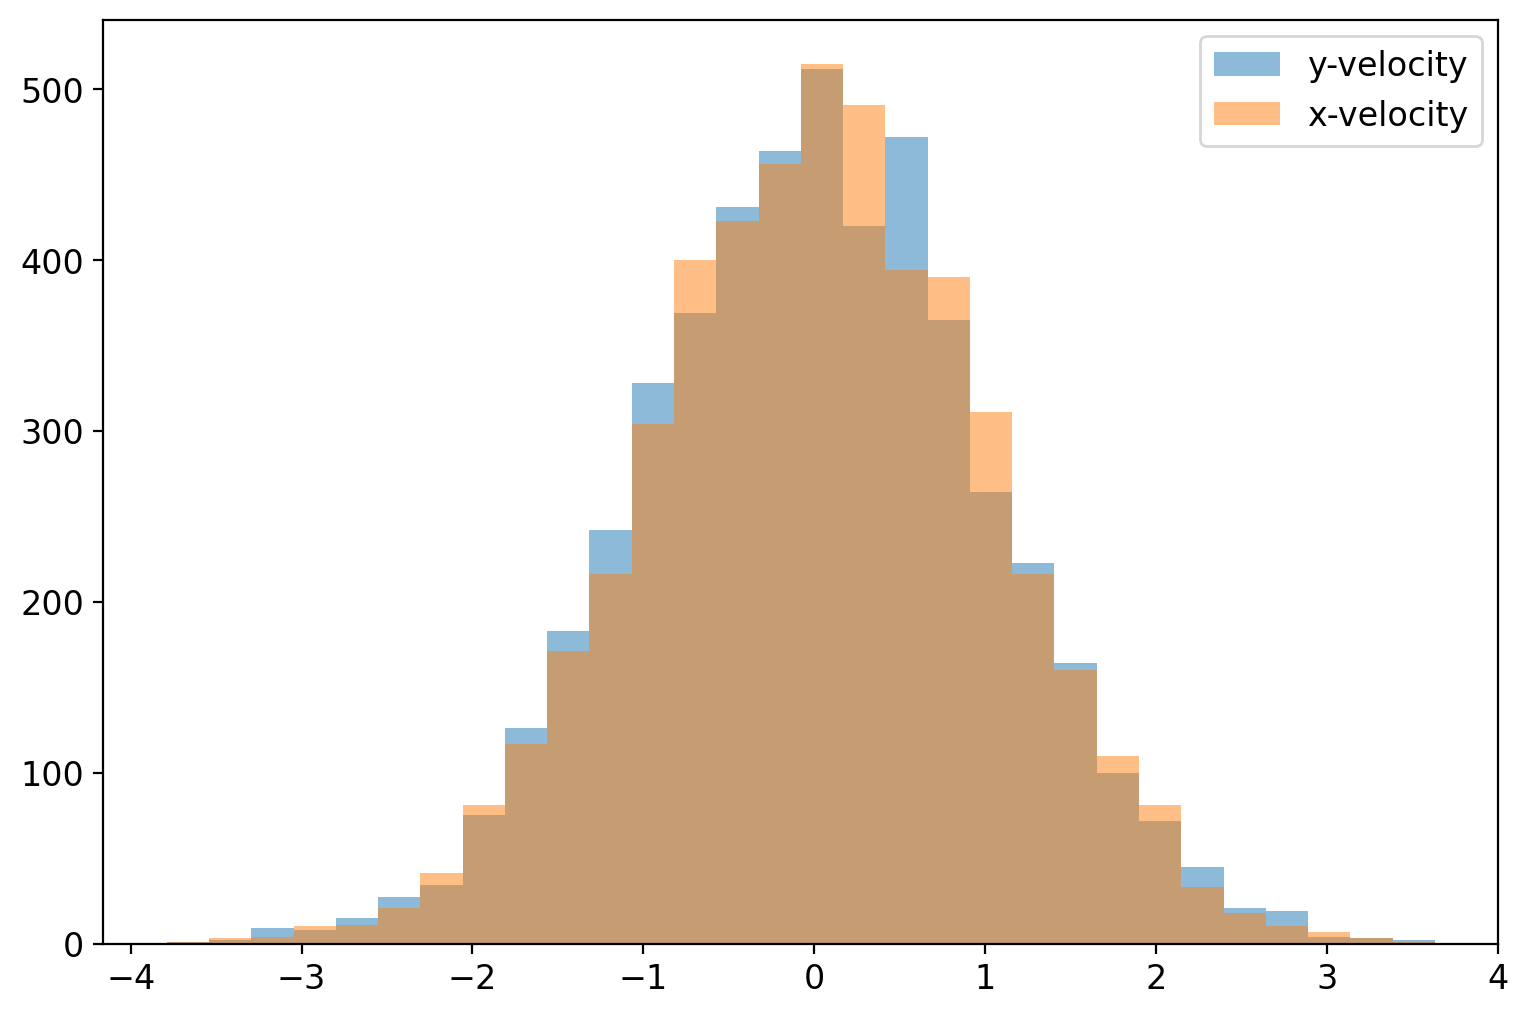

In [ ]:

MCSim(sigmav=100,dt=0.001,nsteps=100000,ntoys=5000)
MCSim(sigmav=1,dt=0.1,nsteps=100000,ntoys=5000)

### <span style="border:3px; border-style:solid; padding: 0.15em; border-color: #90409C; color: #90409C;">Ex-21.3.2</span>

What would the distribution of the particles look like if you had a box distribution in $x$ and $y$ with edge of 2?

In [ ]:
def MCSim(sigmav=1,nsteps=10000,ntoys=5000,dt=0.01,iDump=True):
    partpos=np.zeros((ntoys,2)) #x and y
    partvel=np.random.normal(0,sigmav,(ntoys,2))
    for t0 in range(nsteps):
        opartvel = np.random.normal(0,sigmav,(ntoys,2))
        partpos += partvel*dt
        comvel   = 0.5*(partvel + opartvel)
        difvel   = 0.5*(partvel - opartvel)
        theta = np.random.uniform(0,2.*np.pi,ntoys)#elastic collisiosn in the COM equate to equal energy ad a theta rotation
        R     = np.array(((np.cos(theta), -1*np.sin(theta)), (np.sin(theta), np.cos(theta))))
        RMat  = np.swapaxes(R,0,2)
        #tmp2=np.matmul(RMat[0],difvel[0])
        tmp=np.einsum('BNi,Bi ->BN', RMat, difvel)
        inbox  = (partpos[:,0]**2 < 4)  & (partpos[:,1]**2 < 4)
        partvel[inbox]  = comvel[inbox]+tmp[inbox]
        partvel[~inbox] = -partvel[~inbox]
    if iDump:
        _,bins,_=plt.hist(partpos[:,1],bins=30,alpha=0.5,label='y-position')
        plt.hist(partpos[:,0],bins=bins,alpha=0.5,label='x-position')
        plt.legend()
        plt.show()
        _,bins,_=plt.hist(partvel[:,1],bins=30,alpha=0.5,label='y-velocity')
        plt.hist(partvel[:,0],bins=bins,alpha=0.5,label='x-velocity')
        plt.legend()
        plt.show()
MCSim()

<a name='section_21_4'></a>
<hr style="height: 1px;">

## <h2 style="border:1px; border-style:solid; padding: 0.25em; color: #FFFFFF; background-color: #90409C">L21.4 Modelling Physics Observables: Bragg Scattering for Proton Therapy</h2>  

| [Top](#section_21_0) | [Previous Section](#section_21_3) | [Exercises](#exercises_21_4) | [Next Section](#section_21_5) |

There are a broad range of physics processes that we can use Monte Carlo to simulate. They typically involve scenarios where we don't have a good understanding of the analytic form of the whole system, but we understand how it works.

We can embed all of our knowledge into understanding how the system works into a simulation. A simulation that relies on sampling of events, and modelling the effects in an event by event way is deemed a Monte-Carlo simulation, there are a huge number of Monte Carlo simulations.

Lets start by simulating a particle passing through matter. This is one of the most common simulations, because we understand all the different sub processes well, but when we put them all together they are rather complicated.

We will do this in the context of proton therapy data. Proton therapy is a way to treat cancerous cells through a non invasive approach whereby we fire energetic proton beams to various body parts. These beams are precisely controled to deliver a dose of radiation at just the right spot. Let's go ahead and do a simple simulation.

What we are going to do first, is model the energy loss in matter, given by

$$
-\frac{dE}{dx} = \frac{4\pi \rho N_{A} z^2}{ M_{u} m_{e}c^{2}\beta^{2}}\frac{Z}{A}\left(\frac{e^{2}}{4\pi\epsilon_{0}}\right)^{2}\left(\log\left(\frac{2\gamma^{2}m_{e}c^{2}\beta^{2}T_{\rm max}}{I(1-\beta)^{2}}\right)-\beta^{2}-\frac{\delta(\beta\gamma)}{2}\right)
$$

Now to get this to work completely we need to compute the Ionization energy. The ionization energy is stored in a bunch of places. In particular, you can find it in [figure 34.5](https://pdg.lbl.gov/2022/reviews/rpp2022-rev-passage-particles-matter.pdf), this depends on the nuclear stucture, but is roughly flat as a function of the nuclear charge as you get to higher elements. For our purposes, we will will just parameterize this as as table.

In addition, we also need the atomic masses $A$ of all the objects, we can again take this from an online source. For people familiar, we are taking this from the particle simulation code Geant in Fortran. Let's plot them below.

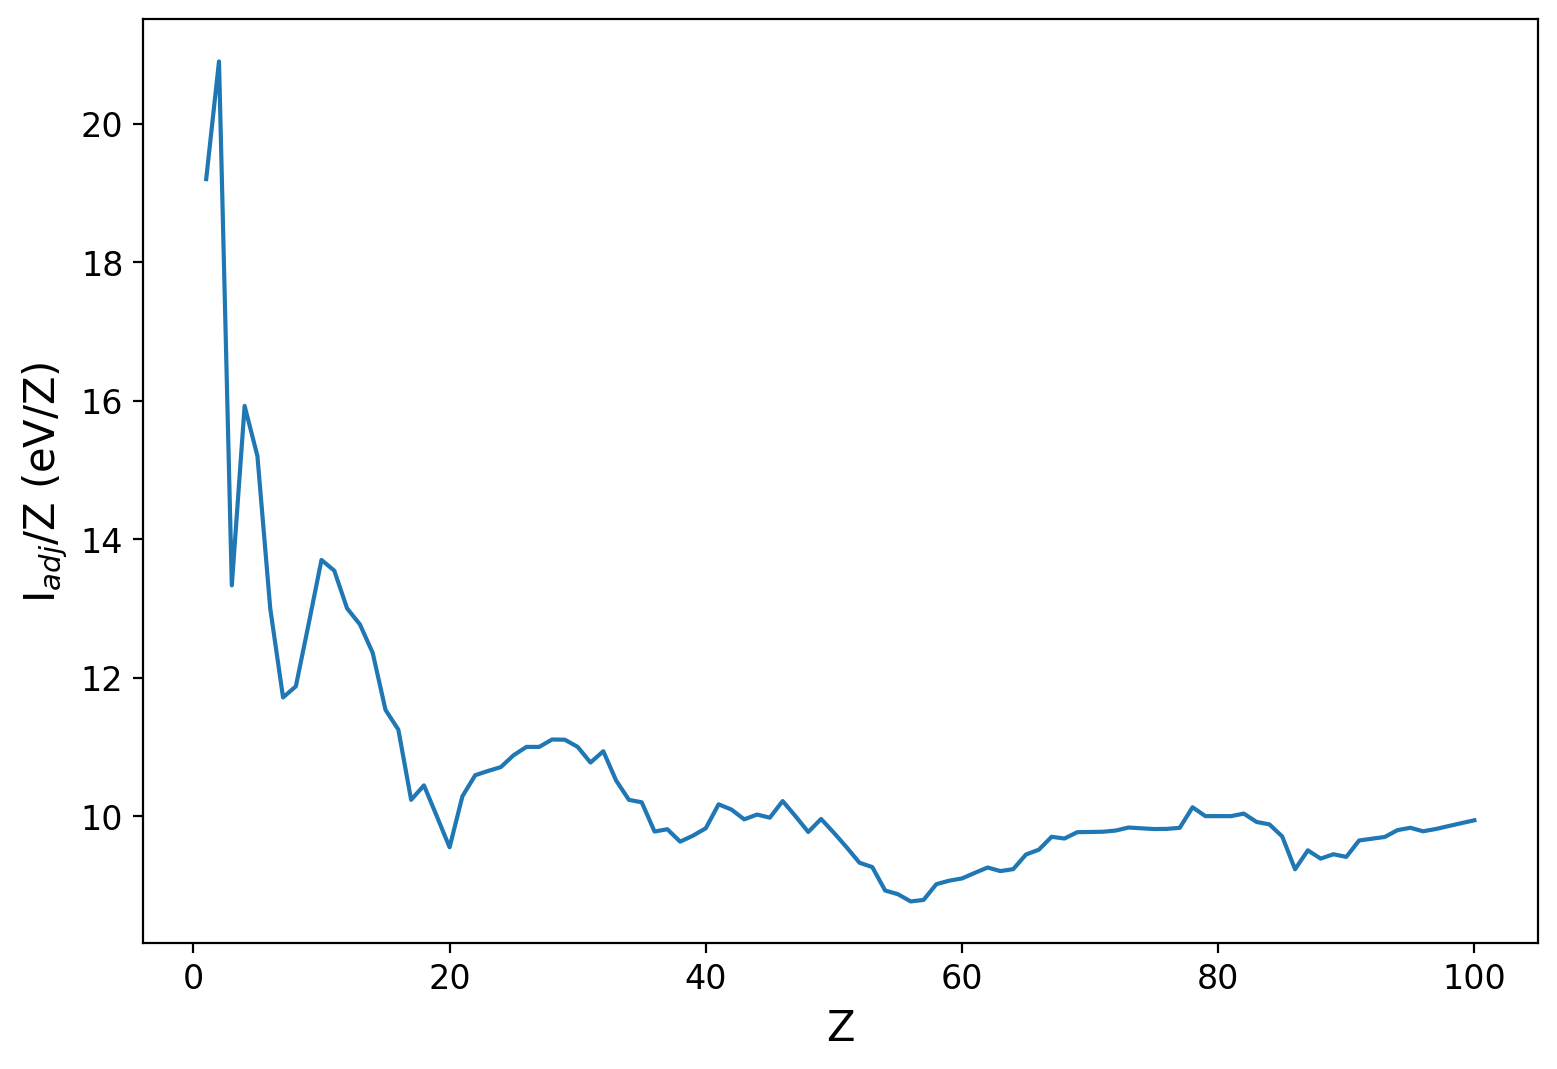

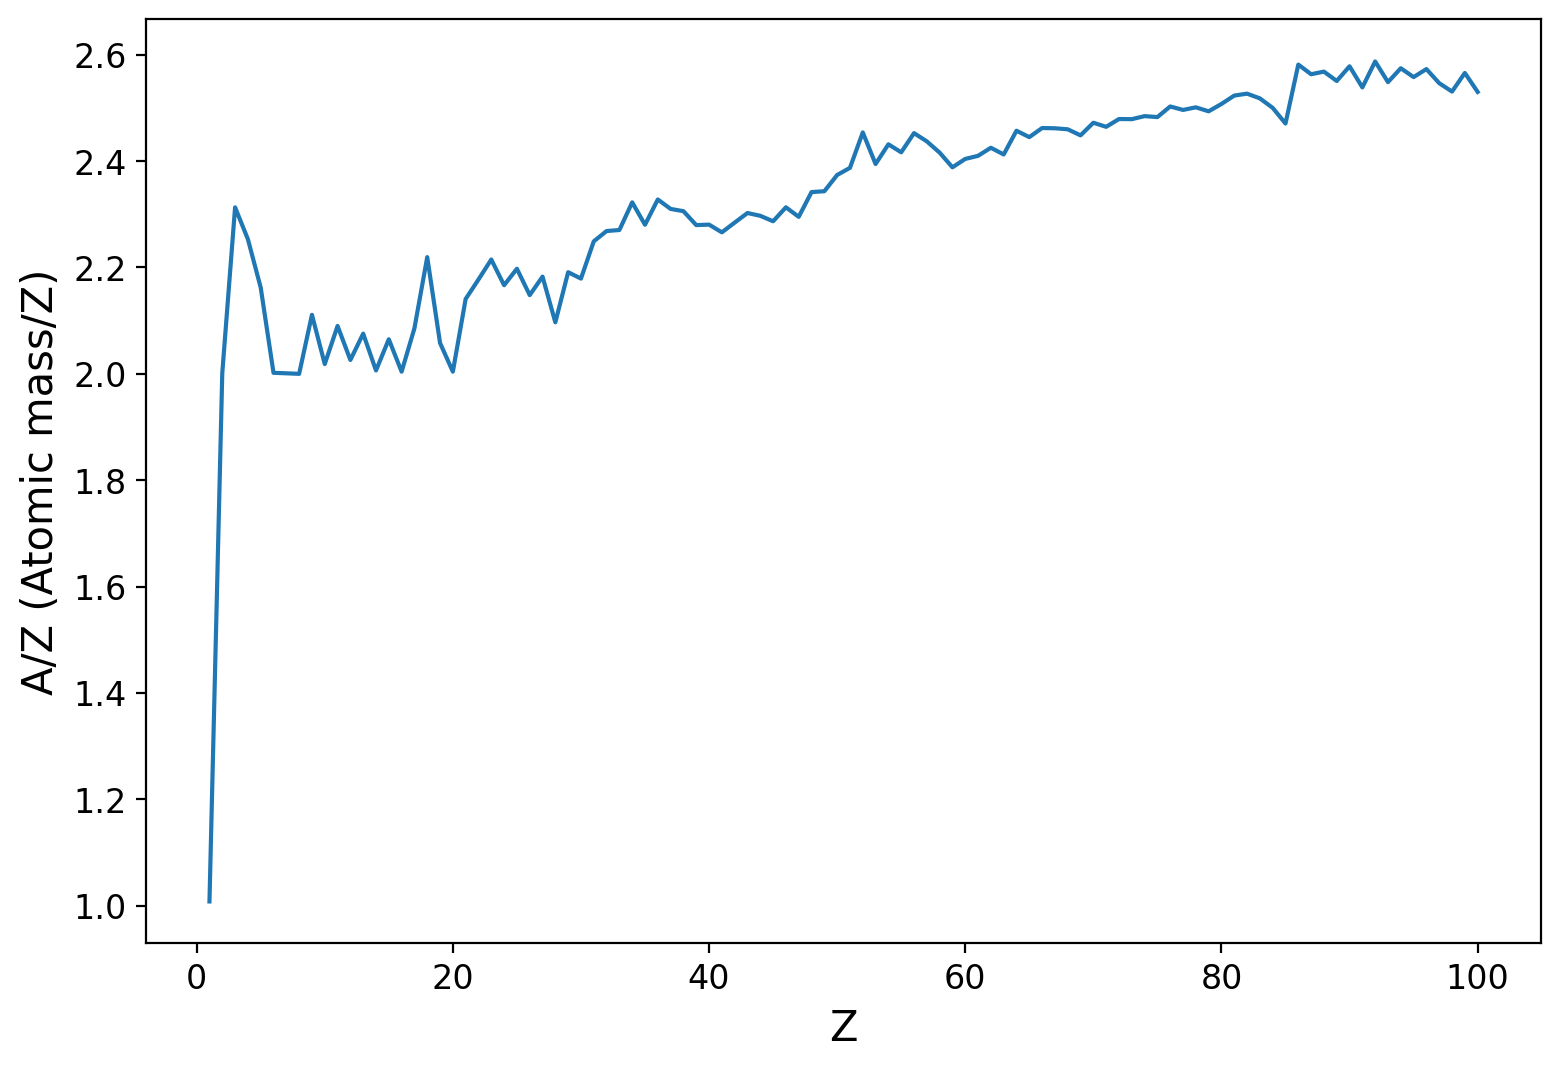

In [77]:
#values
def I(iZ,iPlot=False):
    #https://github.com/nrc-cnrc/EGSnrc/blob/master/HEN_HOUSE/pegs4/pegs4.mortran#L1354-L1391
    lI=[19.2,41.8,40.,63.7,76.0,78.0,82.0,95.0,115.,137.,
     149.,156.,166.,173.,173.,180.,174.,188.,190.,191.,216.,233.,245.,
     257.,272.,286.,297.,311.,322.,330.,334.,350.,347.,348.,357.,352.,
     363.,366.,379.,393.,417.,424.,428.,441.,449.,470.,470.,469.,488.,
     488.,487.,485.,491.,482.,488.,491.,501.,523.,535.,546.,560.,574.,
     580.,591.,614.,628.,650.,658.,674.,684.,694.,705.,718.,727.,736.,
     746.,757.,790.,790.,800.,810.,823.,823.,830.,825.,794.,827.,826.,
     841.,847.,878.,890.,902.,921.,934.,939.,952.,966.,980.,994.]
    lZ=np.arange(1,len(lI)+1)
    if iPlot:
        plt.plot(lZ,lI/lZ)
        plt.xlabel('Z')
        plt.ylabel('I$_{adj}$/Z (eV/Z)')
        plt.show()
    return lI[iZ]*1e-6 #MeV not eV
def A(iZ,iPlot=False):
    #https://github.com/nrc-cnrc/EGSnrc/blob/master/HEN_HOUSE/pegs4/pegs4.mortran#L1354-L1391
    lA=[1.00797,4.0026,6.939,9.0122,10.811,12.01115,14.0067,
     15.9994,18.9984,20.183,22.9898,24.312,26.9815,28.088,30.9738,
     32.064,35.453,39.948,39.102,40.08,44.956,47.90,50.942,51.998,
     54.9380,55.847,58.9332,58.71,63.54,65.37,69.72,72.59,74.9216,
     78.96,79.808,83.80,85.47,87.62,88.905,91.22,92.906,95.94,99.0,
     101.07,102.905,106.4,107.87,112.4,114.82,118.69,121.75,127.60,
     126.9044,131.30,132.905,137.34,138.91,
     140.12,140.907,144.24,147.,150.35,151.98,157.25,158.924,162.50,
     164.930,167.26,168.934,173.04,174.97,178.49,180.948,183.85,
     186.2,190.2,192.2,195.08,196.987,200.59,204.37,207.19,208.980,
     210.,210.,222.,223.,226.,227.,232.036,231.,238.03,237.,242.,
     243.,247.,247.,248.,254.,253.
    ]
    lZ=np.arange(1,len(lA)+1)
    if iPlot:
        plt.plot(lZ,lA/lZ)
        plt.xlabel('Z')
        plt.ylabel('A/Z (Atomic mass/Z)')
        plt.show()
    return lA[iZ-1]
lItmp=I(1,True)
lItmp=A(1,True)

Now we have all the elements to compute the Bethe-Bloch formula, and look at the charged particle energy loss over distance. For this part, we are going to focus on protons. However, this generally applies to a lot of different phenomena.  

Additionally, we will plot this for two atomic elements. Since we care about the human body, we will plot this for water (Oxygen) and just to show something heavy thats in a human (calcium). See this [page](https://en.wikipedia.org/wiki/Composition_of_the_human_body)

1.0056667694537882 0.10600907909112761


/var/folders/4t/mwl83f3x1ls0jvy35v4qzj7c0000gp/T/ipykernel_8329/476672178.py:31: RuntimeWarning: invalid value encountered in power
  f2 = 2 * x * np.log(10) - C + (a * ((X1 - x)**m))


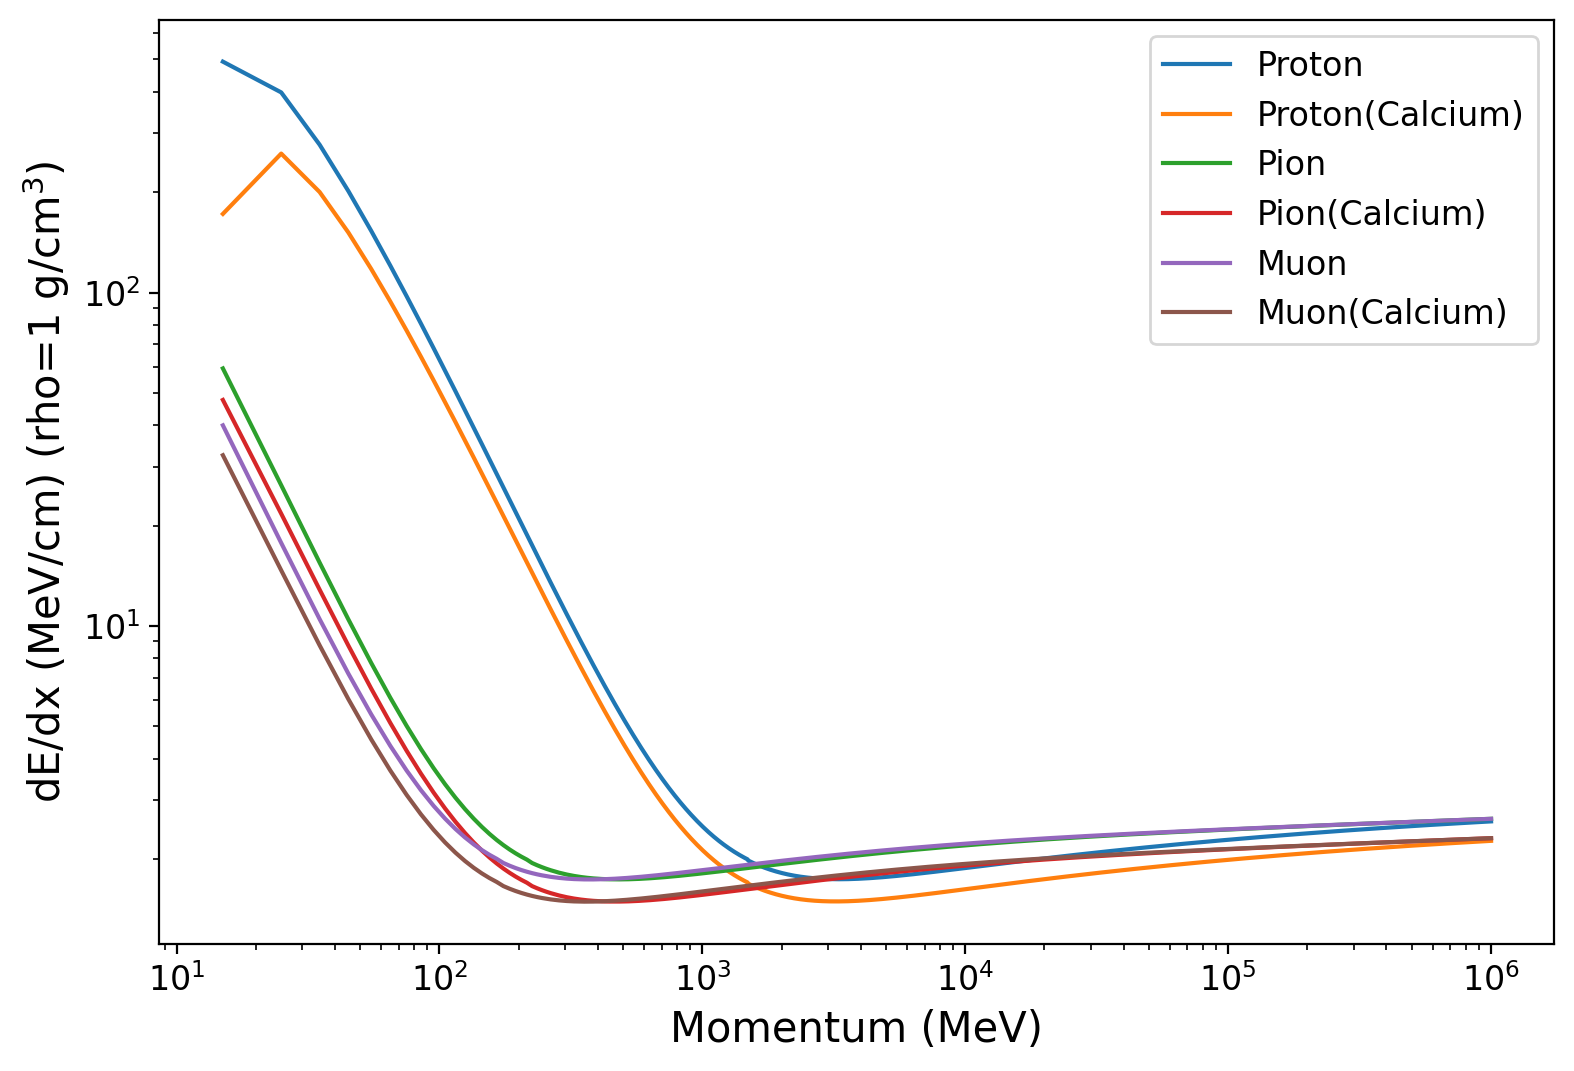

0.7059732966763472

In [78]:
#https://indico.cern.ch/event/753612/contributions/3121551/attachments/1974578/3285956/MC_2019.pdf
#https://www.nature.com/articles/s41598-017-10554-0

m_e = 0.511 # Mass of electron in MeV

def gamma(ip,im): #E^2=gamma^2m^2=p^2+m^2
    return np.sqrt(1+(ip/im)**2)

def beta(ip,im): #gamma=1/sqrt(1-b^2)
    g=gamma(ip,im)
    return np.sqrt(1-1./g**2)

def betagamma(ip,im):#p=bgm
    return ip/im

def Tmax(ip,im): # Maximum energy transfer in one collision in MeV
    return 2*m_e*(ip/im)**2/(1+2*gamma(ip,im)*m_e/im+(m_e/im)**2)

def TKinheavy(ip,im): #(T+M)^2=sqrt(p)+sqrt(m)
    return np.sqrt(np.sqrt(ip)+np.sqrt(um))-im

def delta(ip,im):
    C = 4.44
    a = 0.1492
    m = 3.25
    X1 = 2.87
    X0 = 0.2014
    delta0 = 0.14
    x = np.log10(ip/im)
    #f1 = lambda x: delta0 * 10**(2*(x-X0)) # conductors pdg
    f2 = 2 * x * np.log(10) - C + (a * ((X1 - x)**m))
    f3 = 2 * x * np.log(10) - C
    delta_full = np.where(x < X0, 0, f2)
    delta_full = np.where(x < X1 ,delta_full, f3)
    return delta_full

def dEdxF(ip,im,iZ,zpart=1,rho=1.0,nodelta=False): #Bethe-Bloch equation
    K = 0.307075 # constant K in MeV cm mol^-1
    #rho = 2.336 # Density of material in g cm^-3 (here: silicon density)
    const   = zpart**2 * (K * rho * iZ ) / (2 * A(iZ)) * (1./beta(ip,im)**2)
    logterm = 2 * m_e * Tmax(ip,im) * ((ip/im)**2)/(I(iZ)**2)
    dEdxV   =  const * (np.log(logterm)  - 2*(beta(ip,im))**2 - delta(ip,im))
    if nodelta:
        print("delta:",delta(ip,im),dEdxV)
        dEdxV    =  const * (np.log(logterm) - 2*(beta(ip,im))**2)
    return dEdxV

mproton=938
mpion=135.4
mmuon=105.4
print(gamma(100,mproton),beta(100,mproton))
p=np.arange(15,1000000,10)
dEdxOut1p = dEdxF(p,mproton,8,1)
dEdxOut2p = dEdxF(p,mproton,18,1)
dEdxOut1pi = dEdxF(p,mpion,8,1)
dEdxOut2pi = dEdxF(p,mpion,18,1)
dEdxOut1mu = dEdxF(p,mmuon,8,1)
dEdxOut2mu = dEdxF(p,mmuon,18,1)

plt.plot(p,dEdxOut1p,label="Proton")
plt.plot(p,dEdxOut2p,label="Proton(Calcium)")

plt.plot(p,dEdxOut1pi,label="Pion")
plt.plot(p,dEdxOut2pi,label="Pion(Calcium)")

plt.plot(p,dEdxOut1mu,label="Muon")
plt.plot(p,dEdxOut2mu,label="Muon(Calcium)")

plt.xlabel('Momentum (MeV)')
plt.ylabel('dE/dx (MeV/cm) (rho=1 g/cm$^{3}$)')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()

beta(935,mproton)

Now, we can run a basic simulation of this already by considering a particle of a specific energy and then stepping it down by the energy loss. We could in fact do this analytically, but using the above formula makes it particulary nice and elegant. Let's go ahead and run our simulation for our proton energy beam.

An important point to remember is that energy and momentum differ. In otherwords a 350 MeV proton will give a differnt momentum. Note that when we say a 350 MeV proton. We actually mean the kinetic energy is 350 MeV. This means our momentum is given by

$$
p^2 + m^2 = \left(E_{\rm kin} + m\right)^2 \\
p^2 = (E_{kin} + m)^2 - m^2
$$

350 MeV Proton Momemtum: 882.6664149042944


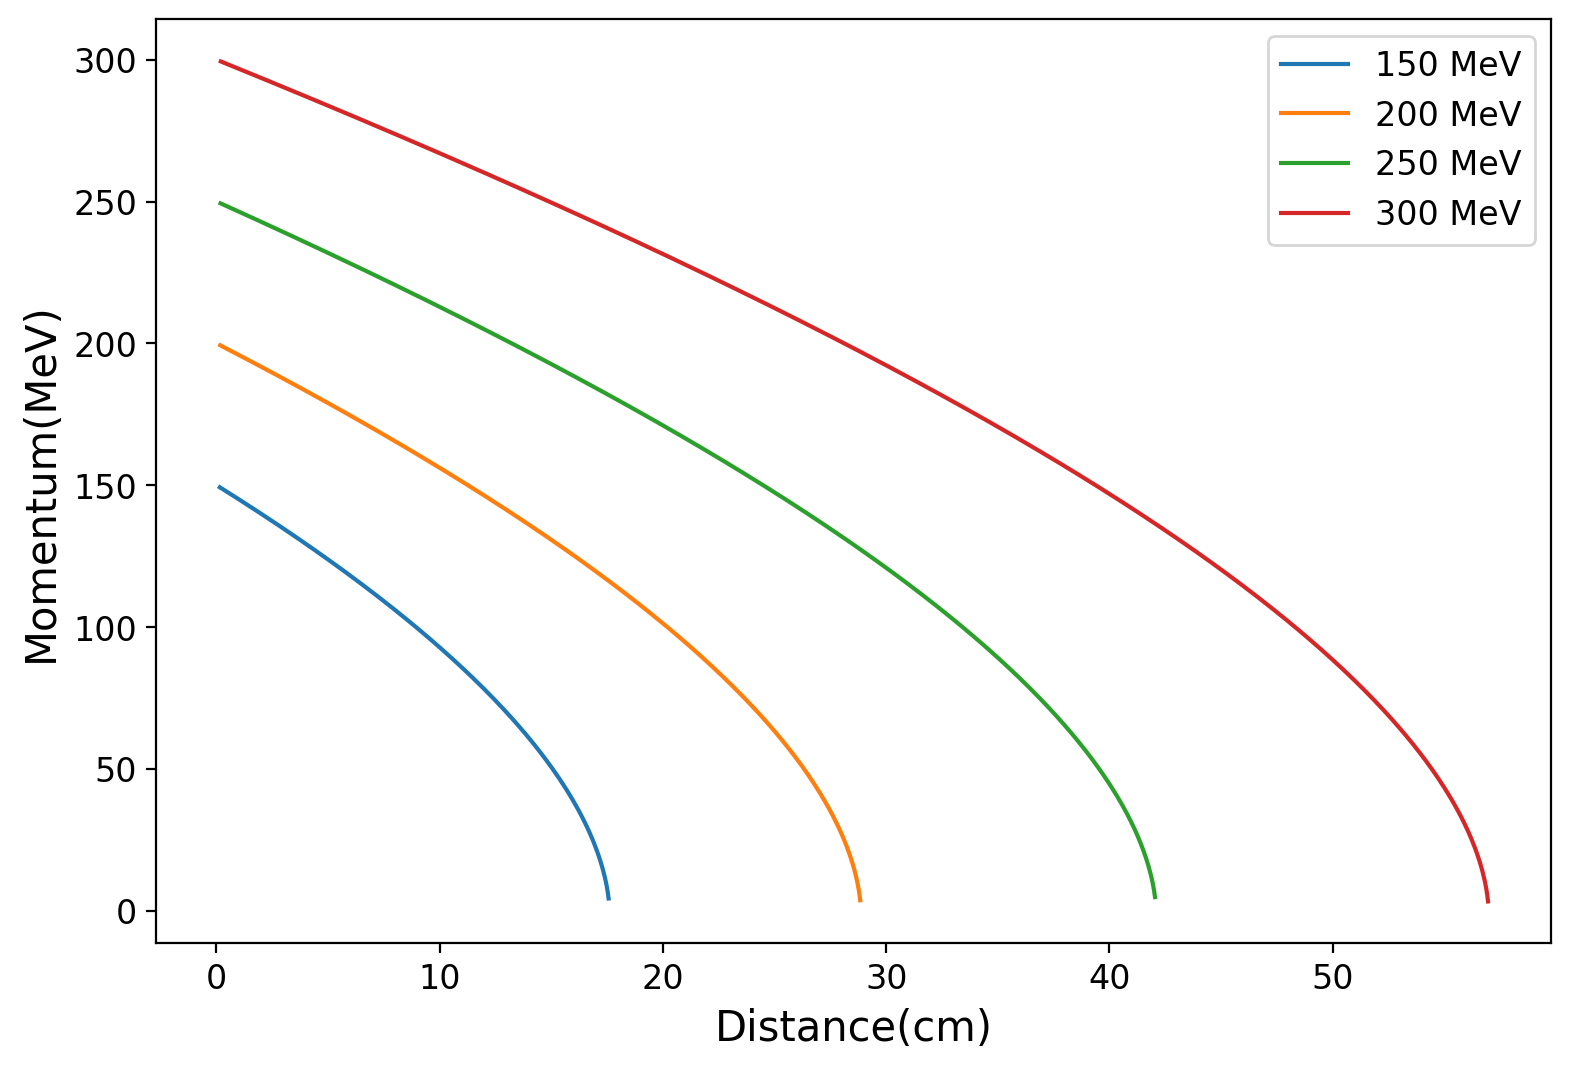

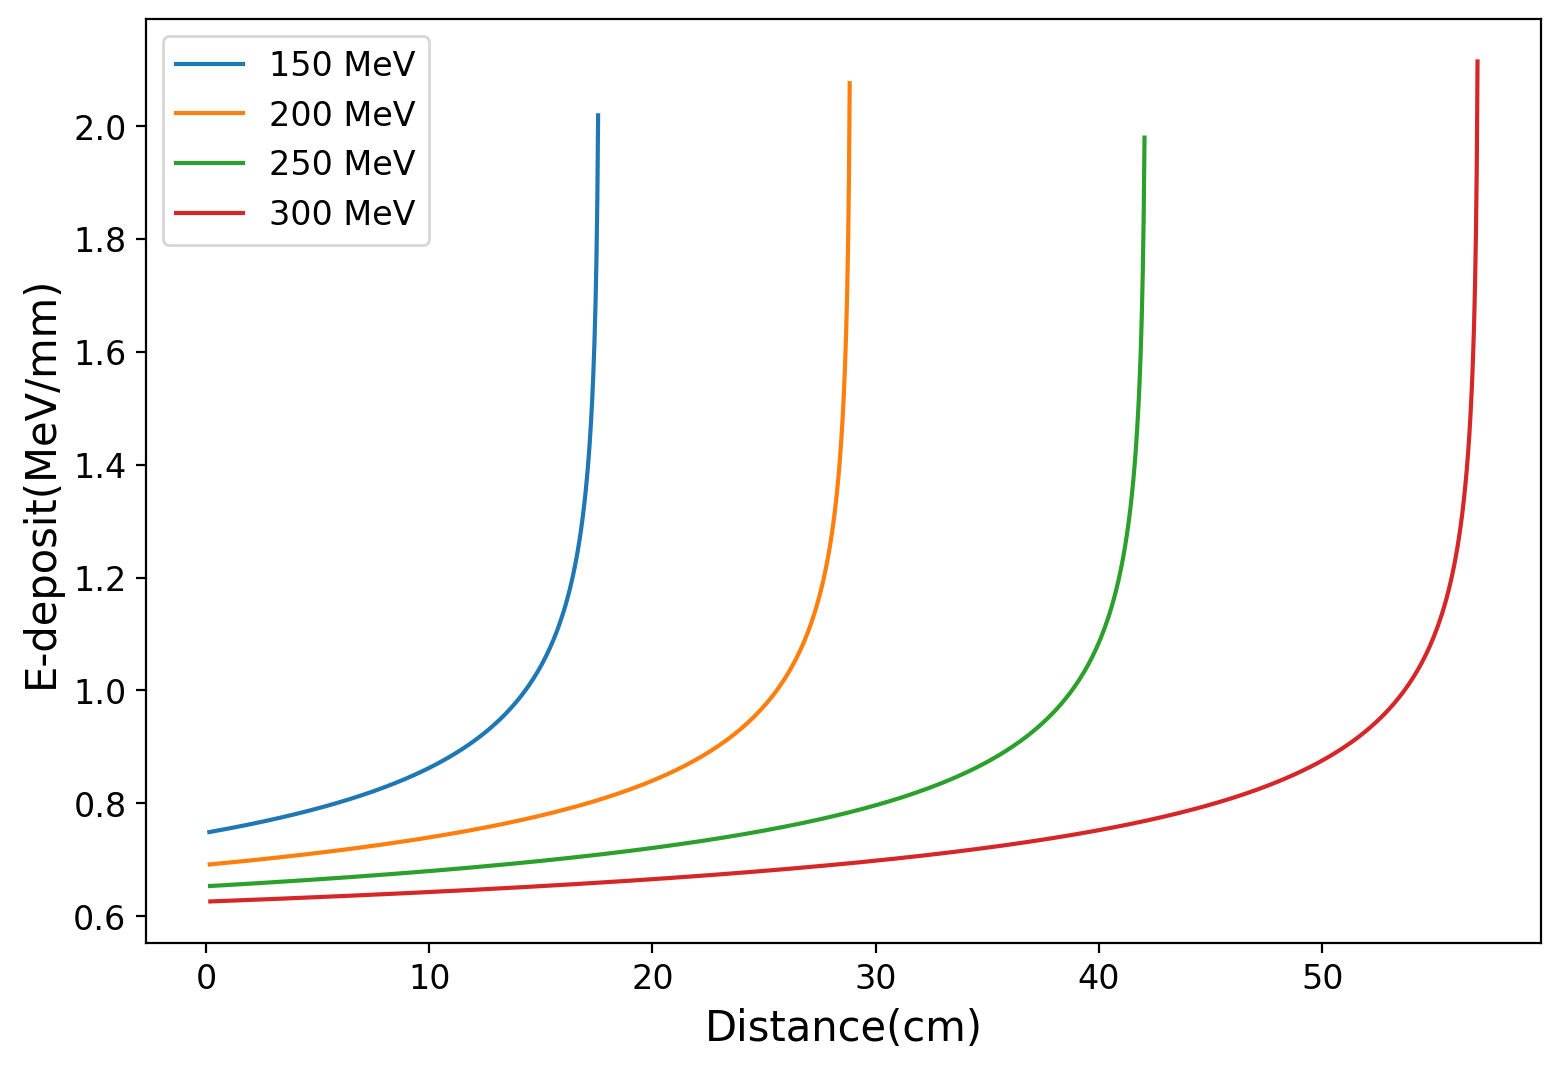

In [79]:
def dP(dE,ip,im): #solving
    #dp = ip - np.sqrt(dE**2+ip**2-2*dE*np.sqrt(ip**2+im**2))
    #E=p^2/2m=> p=\sqrt(2mE)=>dp=sqrt(2m)/sqrt(E) dE
    #return dE*(np.sqrt(ip**2+im**2)/ip)*gamma(ip,im)
    return dE#*(ip/im)

def eToP(iE,im):
    return np.sqrt((iE+im)**2-im**2)

def sim(ie=500,im=935,idt=1e-11,iZ=8):
    xstep  = np.array([])
    estep  = np.array([])
    pstep  = np.array([])
    c=3e10
    dist=0
    e=ie
    while e > 5: #stop at 5 MeV
        p = eToP(e,im)
        dEdxS  = dEdxF(p,im,iZ=iZ,rho=1.06)
        #print(dEdxS)
        dx     = beta(p,im)*c*idt#speed of light
        #print(dEdxS,dP(dEdxS*dx,p,im))
        e      -= dEdxS*dx
        dist   += dx
        xstep  = np.append(xstep,dist)
        estep  = np.append(estep,dEdxS*dx)
        pstep  = np.append(pstep,e)
    return xstep,pstep,estep

print("350 MeV Proton Momemtum:",eToP(350,mproton))
xstep150,pstep150,estep150 = sim(ie=150,im=mproton,idt=1e-11,iZ=8)
xstep200,pstep200,estep200 = sim(ie=200,im=mproton,idt=1e-11,iZ=8)
xstep250,pstep250,estep250 = sim(ie=250,im=mproton,idt=1e-11,iZ=8)
xstep300,pstep300,estep300 = sim(ie=300,im=mproton,idt=1e-11,iZ=8)

plt.plot(xstep150,pstep150,label='150 MeV')
plt.plot(xstep200,pstep200,label='200 MeV')
plt.plot(xstep250,pstep250,label='250 MeV')
plt.plot(xstep300,pstep300,label='300 MeV')
plt.xlabel('Distance(cm)')
plt.ylabel('Momentum(MeV)')
plt.legend()
plt.show()
plt.plot(xstep150,estep150,label='150 MeV')
plt.plot(xstep200,estep200,label='200 MeV')
plt.plot(xstep250,estep250,label='250 MeV')
plt.plot(xstep300,estep300,label='300 MeV')
plt.xlabel('Distance(cm)')
plt.ylabel('E-deposit(MeV/mm)')
plt.legend()
plt.show()

#sim(60,dt=1e-12)

Now what you can see above is that we get a very sharp energy deposit at a very specific region. As a result, we can use proton beams to deposit a huge amount of energy in the body for cancer thereapy. This peak is known as the Bragg peak. You can see that various energy beams get us various ranges in the body. Let's go one step further and make our simulation even more realistic.  

There are three ways to do this:
1. Sample the full energy profile interaction as we move along the decay
2. Smear the initial beam energy by the input resolution
3. Add other effects, namely multiple scattering.

Let's go ahead and start with the first since this is often the most illustrative.

Energy loss is actually governed by a Landau distribution. What that means is that the energy depositied is not a fixed amount per step, but is distribution. The full distribution follows the Landau form given by

$$
p(x) = \frac{1}{\pi}\int_{0}^{\infty} e^{-t \log(t)-xt} \sin(\pi t) dt
$$

To model energy loss exactly, what we need to do is sample a landau distribution at every step and apply the sampled value to our calculation of $\frac{dE}{dx}$. Let's go ahead and plot the Landau and come up with a scheme to sample it.

We will take a resolution of 1.5 percent following [here](https://indico.cern.ch/event/654712/contributions/2666034/attachments/1531773/2397743/SJ_STFCDetectors_ProCal_25-09-17.pdf). Additionally, we will stop our proton beam once we have < 15 MeV.

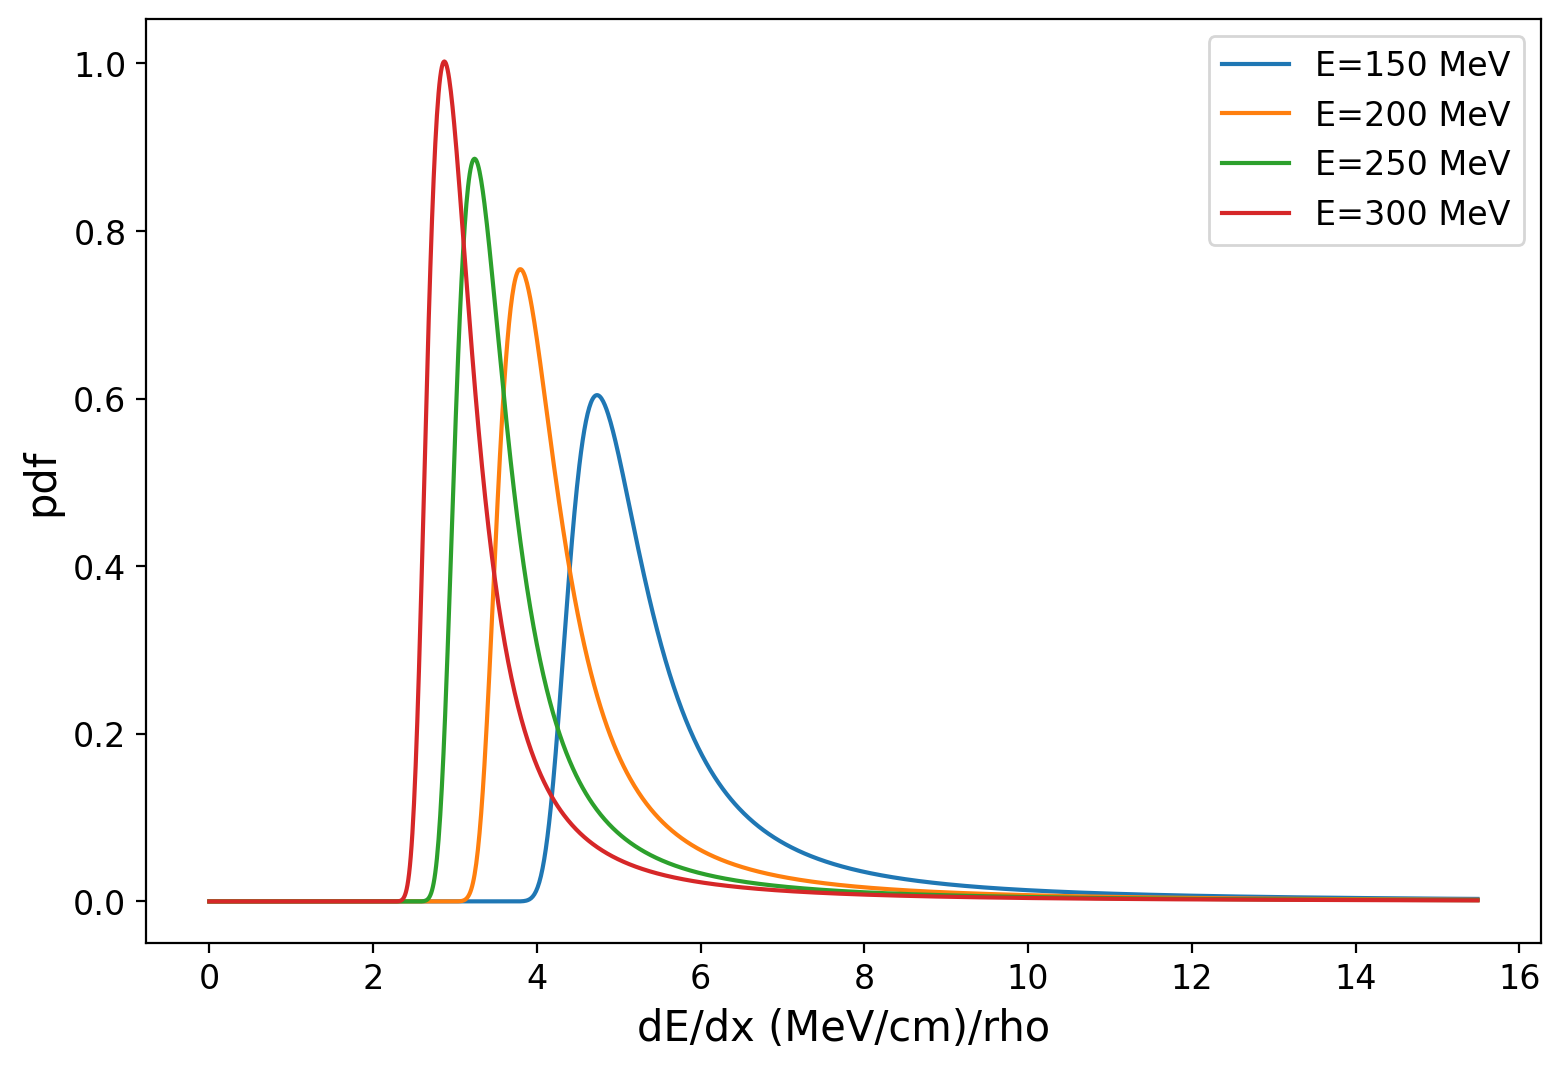

In [80]:
import pylandau
from landaupy import landau

def landauMPV(ip,im,iZ,irho=1,zpart=1):
    K = 0.307075 # constant K in MeV cm mol^-1
    const   = zpart**2 * (K * irho * iZ ) / (2 * A(iZ)) * (1./beta(ip,im)**2)
    #logterm  = 2 * m_e * Tmax(ip,im) * ((ip/im)**2)/(I(iZ)**2)
    logterm1 = 2 * m_e *               ((ip/im)**2)/(I(iZ))
    logterm2 = const/I(iZ)
    dEdxV    =  const * (np.log(logterm1) + np.log(logterm2) + 0.2     - (beta(ip,im))**2 - delta(ip,im))       #
    return dEdxV,const

def plotLandau(ip,im,idx,iZ=14,irho=1,zpart=1):
    lP=eToP(ip,im)
    lMPV,lWMPV = landauMPV(lP,im,iZ,irho,zpart)
    lMPV*=idx; lWMPV*=idx
    x=np.arange(0,15.5,0.01)
    landpy=landau.pdf(x,lMPV,lWMPV)
    return x,landpy

x,landZ150=plotLandau(150,mproton,1.0,iZ=8,irho=1.0)
x,landZ200=plotLandau(200,mproton,1.0,iZ=8,irho=1.0)
x,landZ250=plotLandau(250,mproton,1.0,iZ=8,irho=1.0)
x,landZ300=plotLandau(300,mproton,1.0,iZ=8,irho=1.0)

plt.plot(x,landZ150,label='E=150 MeV')
plt.plot(x,landZ200,label='E=200 MeV')
plt.plot(x,landZ250,label='E=250 MeV')
plt.plot(x,landZ300,label='E=300 MeV')
plt.xlabel("dE/dx (MeV/cm)/rho")
plt.ylabel("pdf")
plt.legend()
plt.show()


Now, what we can do to add some level of realisim as we move along our path of the proton going thorugh matter. Every time we step, we can sample the landau distribution pdf and step our energy loss. Given that we are sampling, it now makes sense to run this experiment a number of times. This now starts to give us some real Monte Carlo description.  

Sampling complicated distributions like this can often be slow. This code was implemented [here](https://github.com/SengerM/landaupy/blob/main/landaupy/samplers.py#L42). The strategy is to randomly sample a number from 0 to 1, this a p-value, then you can get the x-value by inverting the CDF since we know that

$$
\rm{cdf}(x)=\int_{-\infty}^{x} p(x^{\prime}) dx^{\prime}
$$

so we treat the cdf as a 1 to 1 map the y-axis is probabilty and teh x-axis is the pdf value integrated up to $x$. By inverting the cdf, treating this as a lookup table we can ivert the function so that ${\rm cdf}^{-1}(y)=x$.  

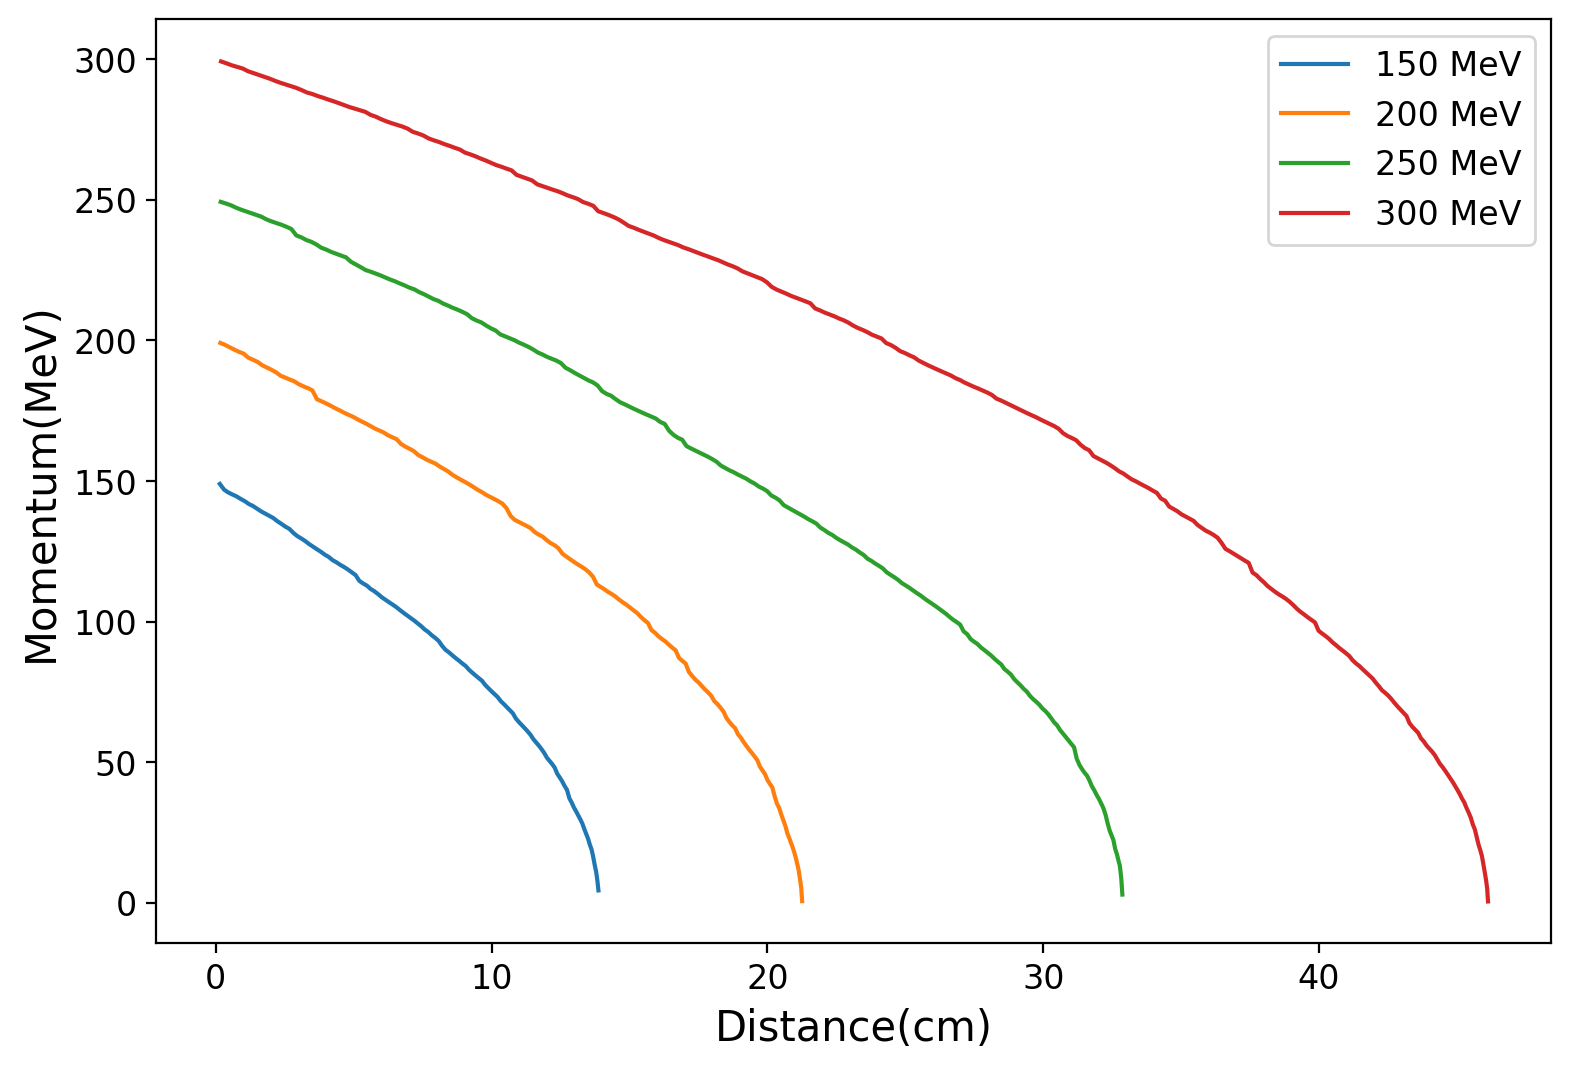

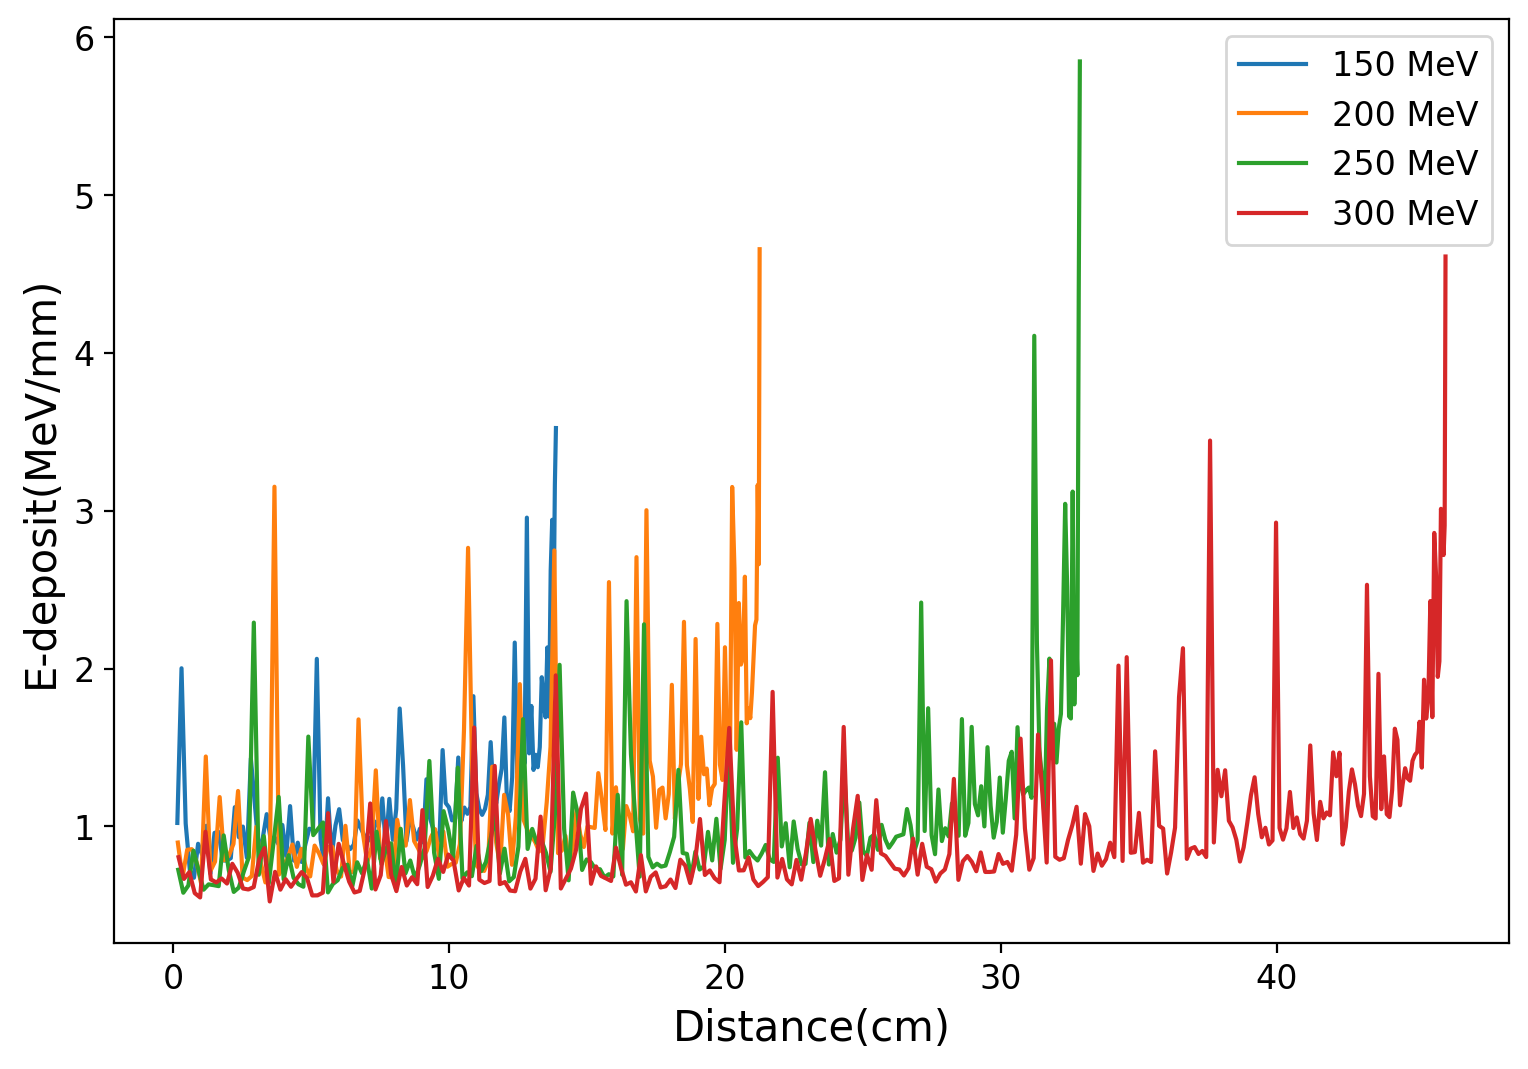

In [81]:
def simSample(ie=500,im=935,idt=1e-11,iZ=8):
    xstep  = np.array([])
    estep  = np.array([])
    pstep  = np.array([])
    c=3e10
    dist=0
    e=ie
    while e > 5:
        p = eToP(e,im)
        lMPV,lWMPV  = landauMPV(p,im,iZ=iZ,irho=1.06)
        dE     = landau.sample(lMPV, lWMPV, 1)
        dx     = beta(p,im)*c*idt#speed of light
        e      -= dE*dx
        dist   += dx
        xstep  = np.append(xstep,dist)
        estep  = np.append(estep,dE*dx)
        pstep  = np.append(pstep,e)
    return xstep,pstep,estep

xstep150,pstep150,estep150 = simSample(ie=150,im=mproton,idt=1e-11,iZ=8)
xstep200,pstep200,estep200 = simSample(ie=200,im=mproton,idt=1e-11,iZ=8)
xstep250,pstep250,estep250 = simSample(ie=250,im=mproton,idt=1e-11,iZ=8)
xstep300,pstep300,estep300 = simSample(ie=300,im=mproton,idt=1e-11,iZ=8)

plt.plot(xstep150,pstep150,label='150 MeV')
plt.plot(xstep200,pstep200,label='200 MeV')
plt.plot(xstep250,pstep250,label='250 MeV')
plt.plot(xstep300,pstep300,label='300 MeV')
plt.xlabel('Distance(cm)')
plt.ylabel('Momentum(MeV)')
plt.legend()
plt.show()
plt.plot(xstep150,estep150,label='150 MeV')
plt.plot(xstep200,estep200,label='200 MeV')
plt.plot(xstep250,estep250,label='250 MeV')
plt.plot(xstep300,estep300,label='300 MeV')
plt.xlabel('Distance(cm)')
plt.ylabel('E-deposit(MeV/mm)')
plt.legend()
plt.show()



Ok so now lets step through this guy and look at the distribution of energy deposited in our system. What we will do is our simulation above 100 times and see how much the energy deposit varies, and how much the length of propagation varies.

For this, we will define a few observables, lets look at the energy deposit in the last 3cm. Also, lets look at the energy deposit in the first 3 cm, for comparison. Also, we can look at the after distance the system went.

0
25
50
75


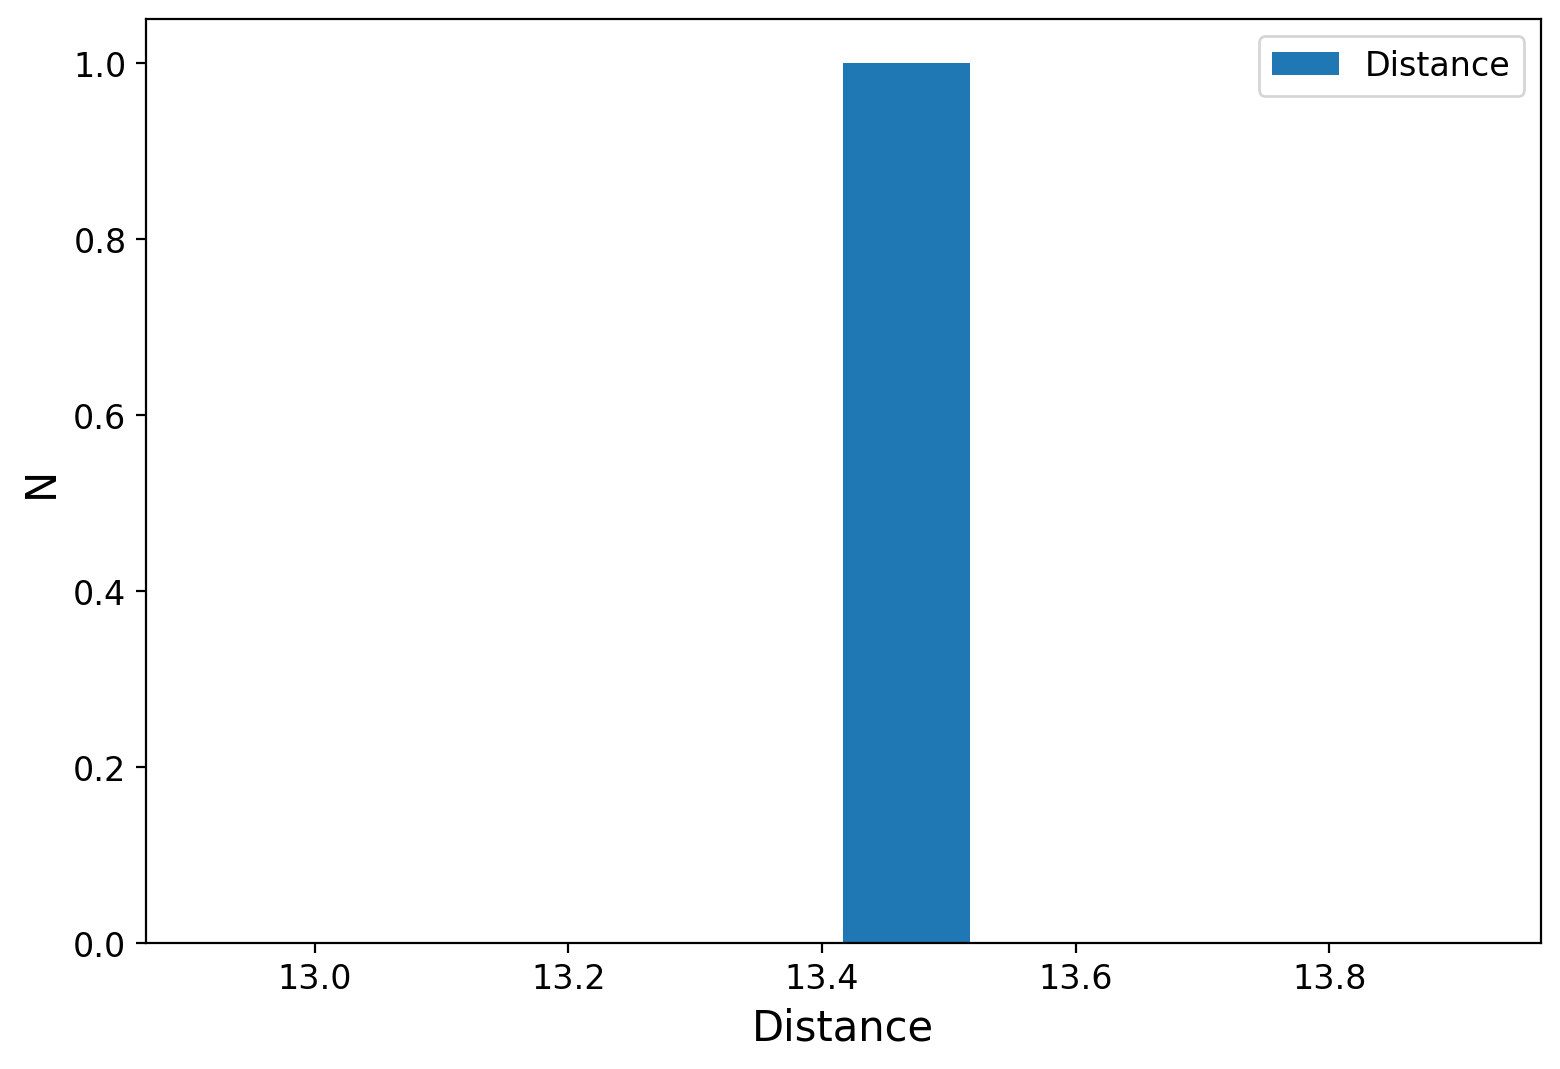

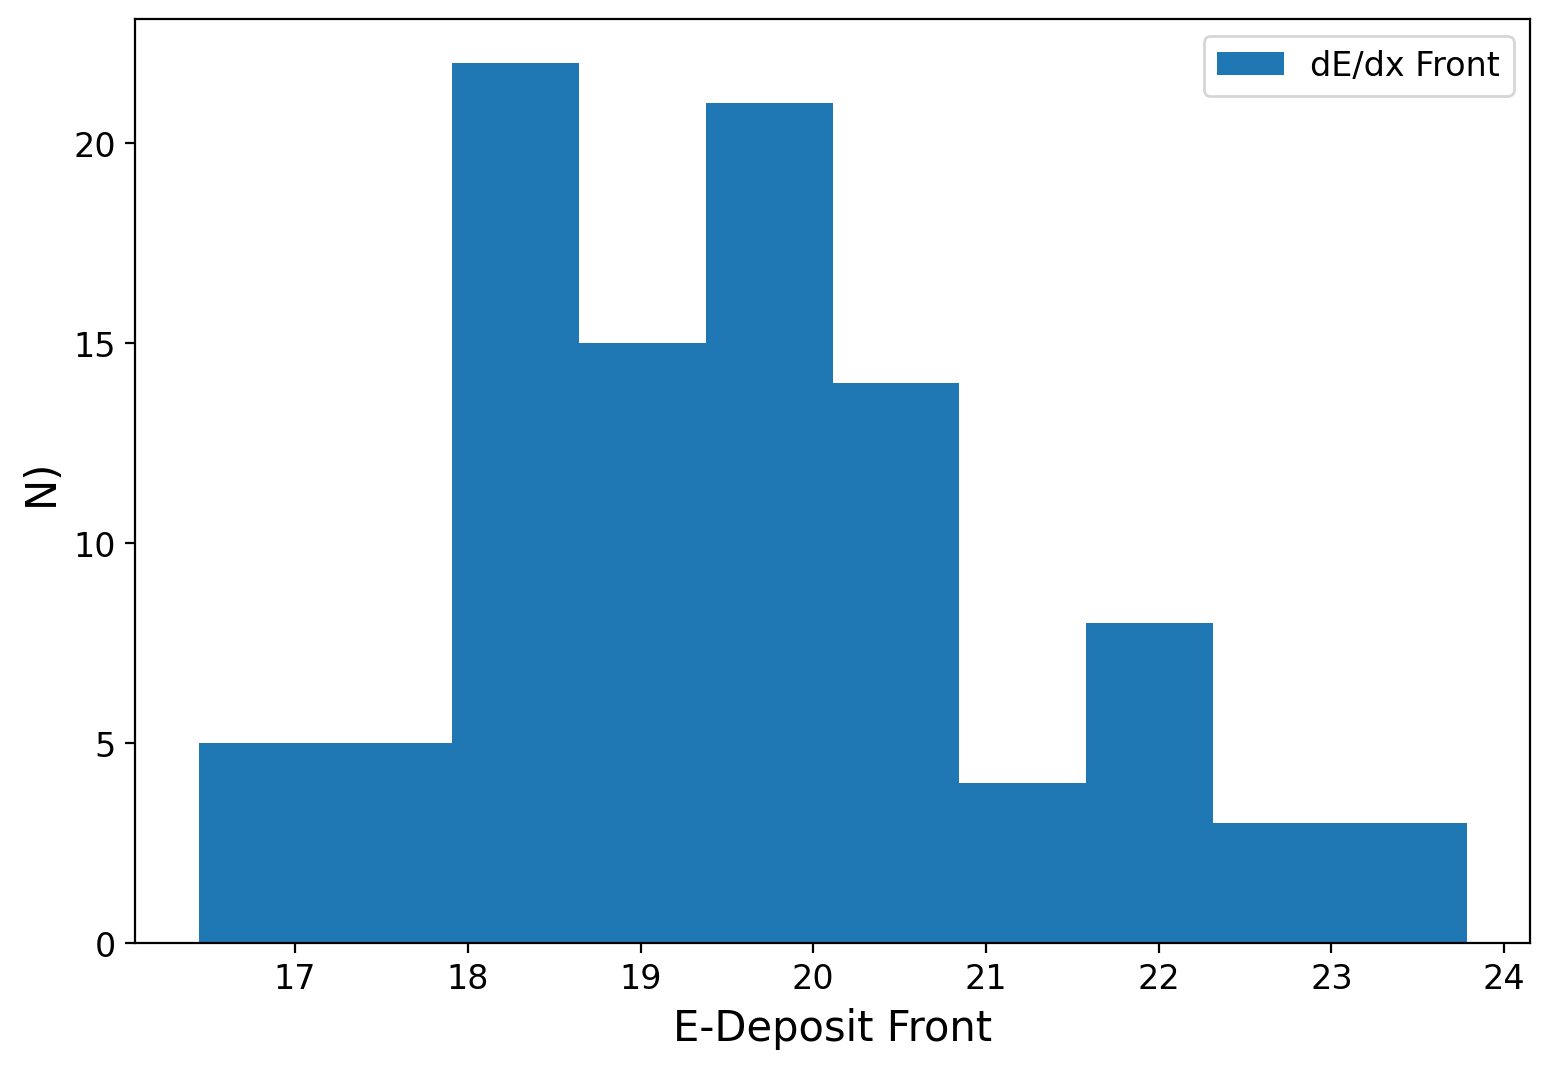

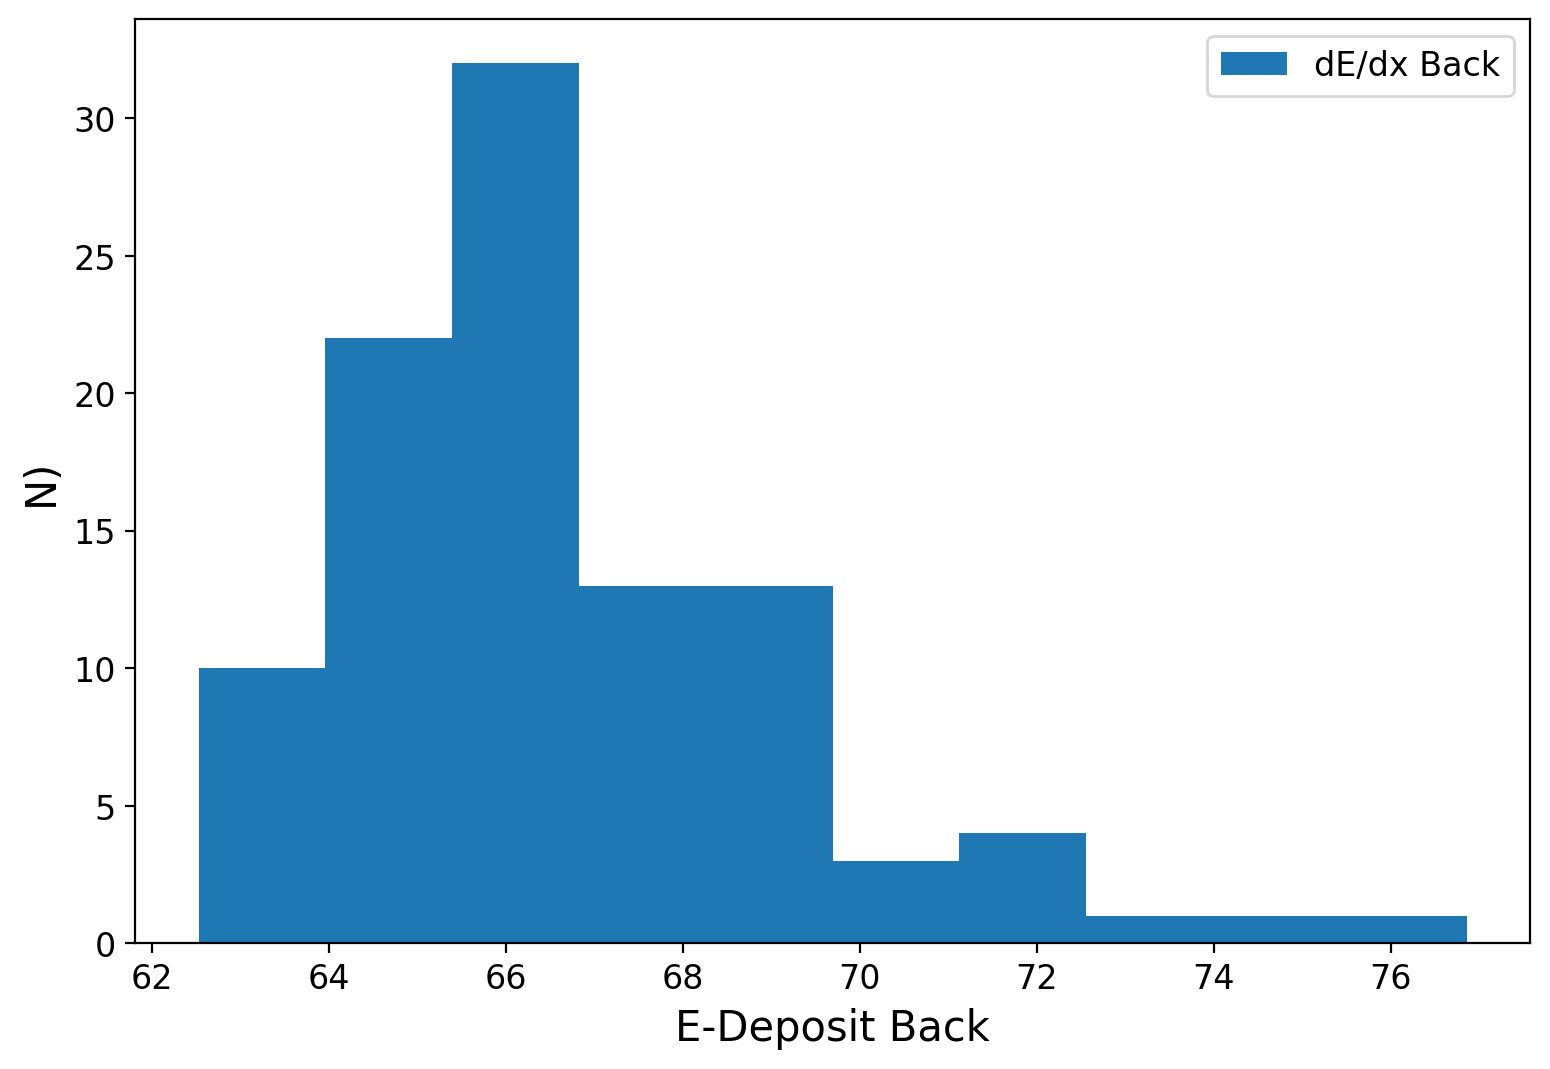

In [82]:
def observables(iXArr,iPArr,iEArr):
    lX=iXArr[-1]
    dEEnd=np.sum(iEArr[(iXArr > iXArr[-1]-3)])
    dEFrt=np.sum(iEArr[(iXArr < 3)])
    return lX,dEEnd,dEFrt

def simNSamples(ie=150,im=mproton,iN=100,idt=1e-11,iZ=8):
    pXArr = np.array([])
    pdEBArr = np.array([])
    pdEFArr = np.array([])
    for i0 in range(iN):
        if i0 % 25 == 0:
            print(i0)
        pXstep,pPstep,pEstep = simSample(ie=ie,im=im,idt=idt,iZ=iZ)
        pX,pdEEnd,pdEFrt = observables(pXstep,pPstep,pEstep)
        pXArr   = np.append(pXArr,  pXstep)
        pdEBArr = np.append(pdEBArr,pdEEnd)
        pdEFArr = np.append(pdEFArr,pdEFrt)

    plt.hist(pX,label='Distance')
    plt.xlabel('Distance')
    plt.ylabel('N')
    plt.legend()
    plt.show()

    plt.hist(pdEFArr,label='dE/dx Front')
    plt.xlabel('E-Deposit Front')
    plt.ylabel('N)')
    plt.legend()
    plt.show()

    plt.hist(pdEBArr,label='dE/dx Back')
    plt.xlabel('E-Deposit Back')
    plt.ylabel('N)')
    plt.legend()
    plt.show()


#plt.plot(xstep150,estep150,label='150 MeV')
#plt.plot(xstep200,estep200,label='200 MeV')
#plt.plot(xstep250,estep250,label='250 MeV')
#plt.plot(xstep300,estep300,label='300 MeV')
#plt.xlabel('Distance(cm)')
#plt.ylabel('E-deposit(MeV/mm)')
#plt.legend()
#plt.show()

simNSamples()


Now that was kind of slow can we speed up this process?

The way we will do this is we will step through 500 simulations all the same time in parallel. The one thing that is tricky is that parallel support for sampling the Landau is not supported, so we will have to add a for loop to do that bit. Anyway, otherwise, we can run everything else in parallel.

Scanning: 150
Scanning: 200
Scanning: 250
Scanning: 300


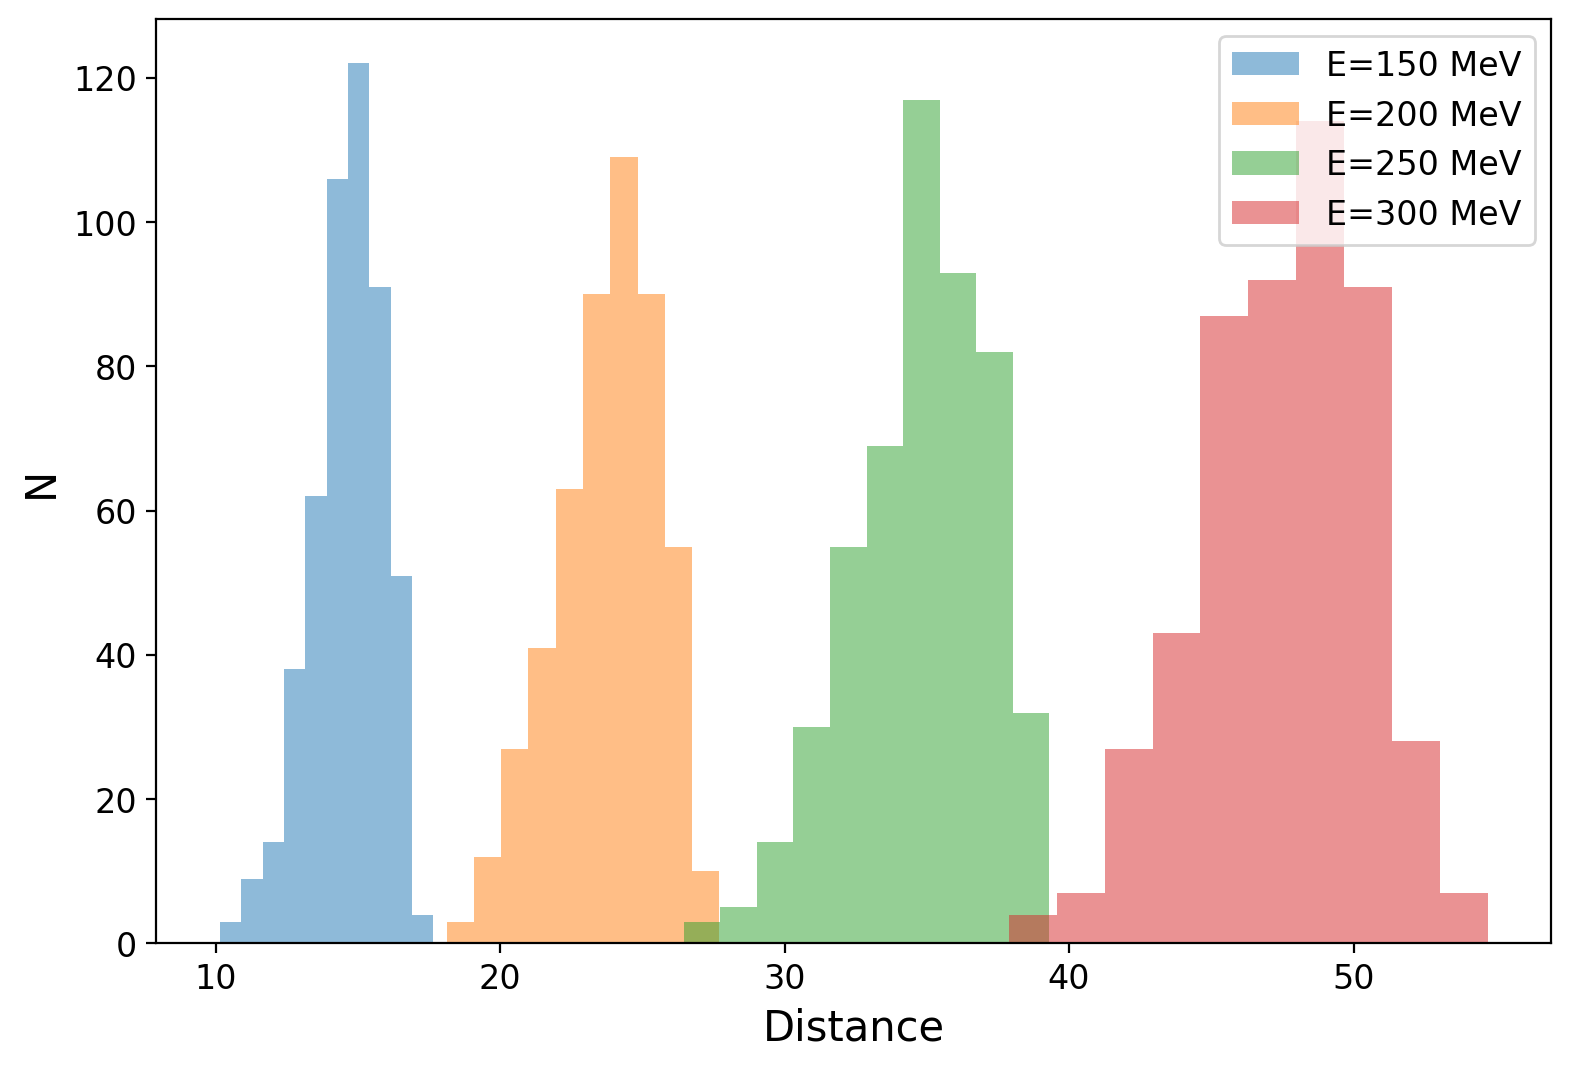

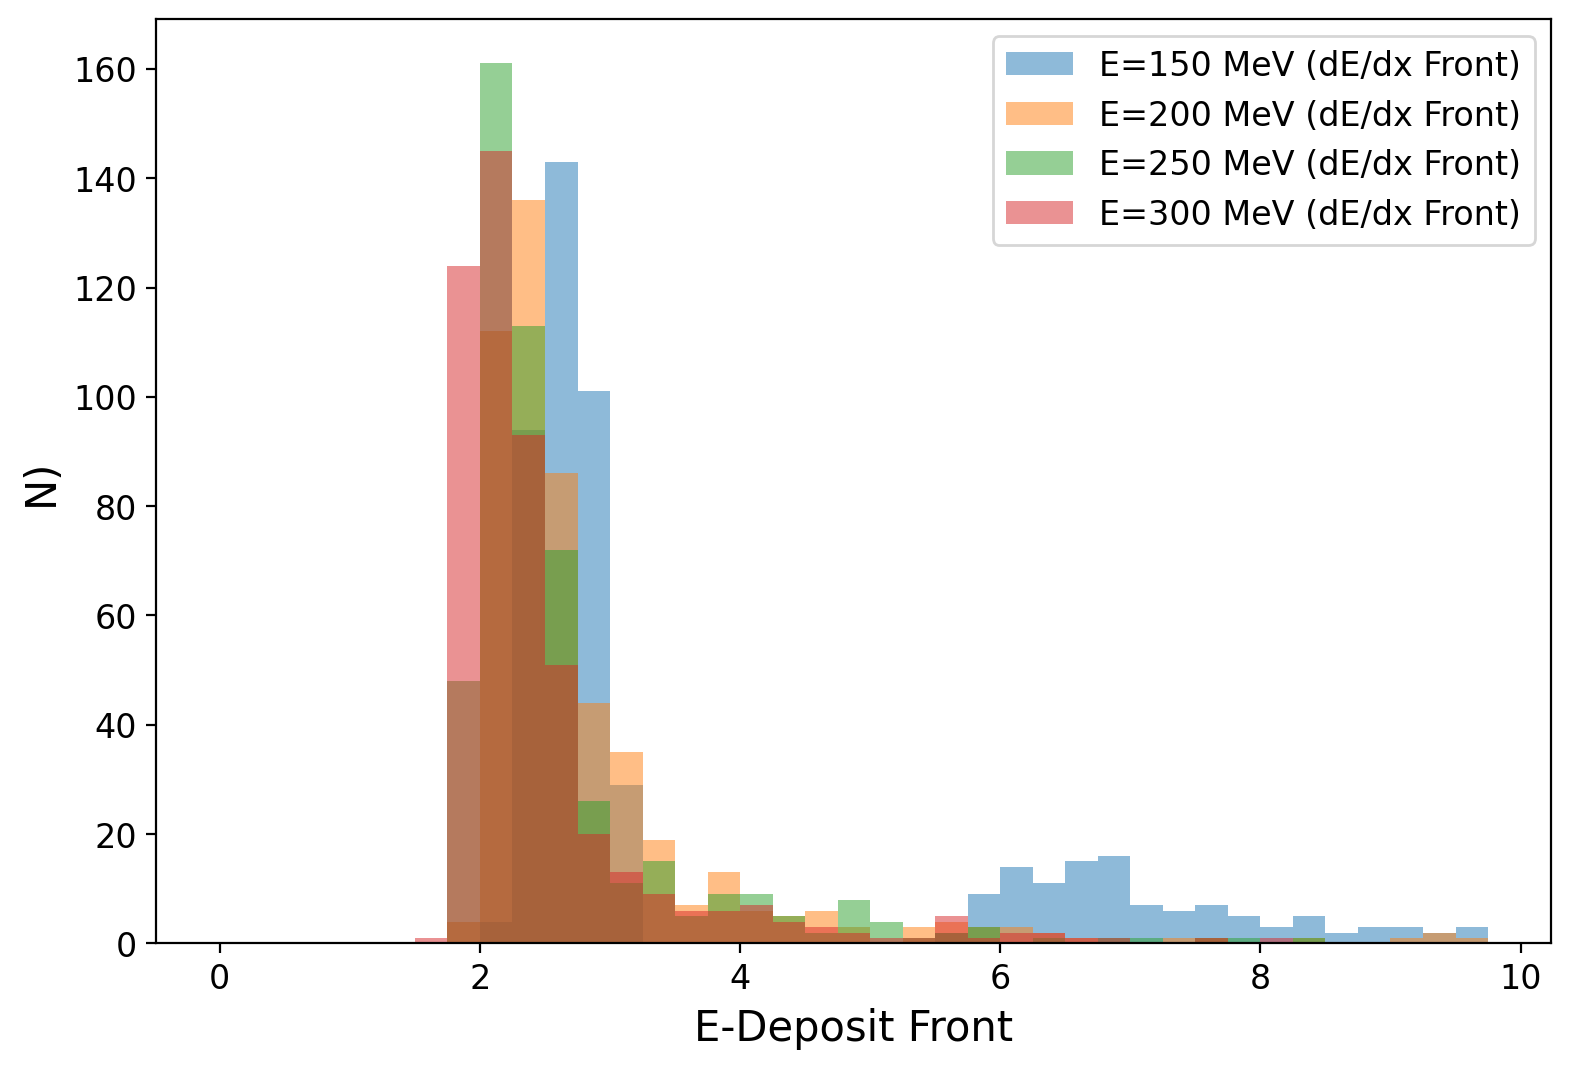

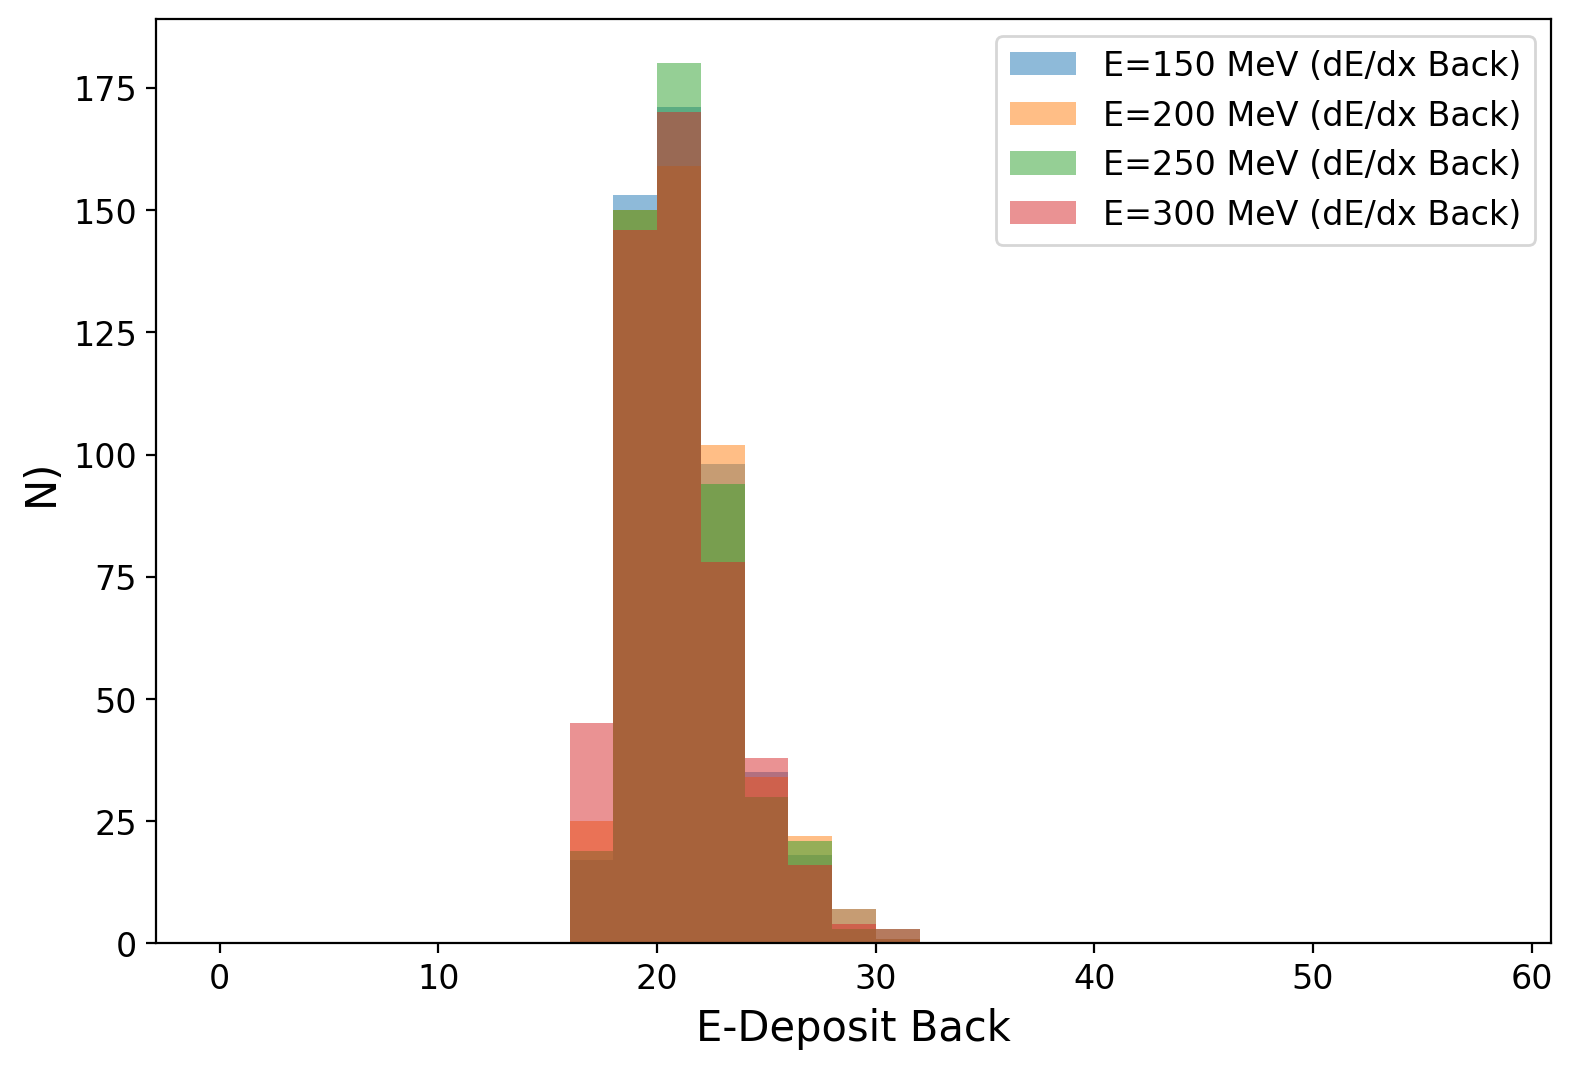

In [83]:
def simNParallelSample(iN, ie=500,im=935,idt=1e-10,iZ=8):
    xstep  = np.empty((0,iN))
    estep  = np.empty((0,iN))
    pstep  = np.empty((0,iN))
    c=3e10
    dist=np.zeros(iN)
    e=np.ones(iN)*ie
    print("Scanning:",ie)
    while np.any(e > 5):
        p = eToP(e,im)
        lMPV,lWMPV  = landauMPV(p,im,iZ=iZ,irho=1.06)
        dE = np.zeros(lMPV.shape)
        ##Here we have to parallelize by hand, this is not good
        for i0, (pMPV,pWMPV) in enumerate(zip(lMPV,lWMPV)):
            dE[i0]     = landau.sample(pMPV, pWMPV,1)
        dx     = beta(p,im)*c*idt#speed of light
        pdEdX  = np.minimum(dE*dx,e-0.1)
        e      -= pdEdX
        dist   += dx
        xstep  = np.vstack((xstep,dist))
        estep  = np.vstack((estep,pdEdX))
        pstep  = np.vstack((pstep,e))
    xstep = xstep.T
    estep = estep.T
    pstep = pstep.T
    return xstep,pstep,estep

def simNSamples(ie=100,im=mproton,iN=500,idt=5e-11,iZ=8):
    xstep,pstep,estep=simNParallelSample(iN,ie=ie,im=im,idt=idt,iZ=iZ)
    plt.hist(xstep[:,-1],alpha=0.5)
    plt.show()
    efront=np.zeros(xstep.shape[0])
    eback =np.zeros(xstep.shape[0])
    for i0 in range(xstep.shape[0]):
        efront[i0] = np.sum(estep[i0,xstep[i0] < 3])/3.
        eback[i0]  = np.sum(estep[i0,xstep[i0] > xstep[i0]-3])/3.
    xrange=np.arange(0,150,2.5)
    _,bins,_=plt.hist(efront,bins=xrange,alpha=0.5,label='dE/dx Front')
    plt.hist(eback, bins=bins,alpha=0.5,label='dE/dx Back')
    plt.legend()
    plt.show()

def sumEstep(estep,xstep):
    efront=np.zeros(xstep.shape[0])
    eback =np.zeros(xstep.shape[0])
    for i0 in range(xstep.shape[0]):
        efront[i0] = np.sum(estep[i0,xstep[i0] < 3])/3.
        #print(xstep[i0] < 3,xstep[i0] > xstep[i0,-1]-3,xstep[i0,-1]-3,xstep[i0],estep[i0])
        eback[i0]  = np.sum(estep[i0,xstep[i0] > xstep[i0,-1]-3])/3.
    return efront,eback

xstep150,pstep150,estep150=simNParallelSample(ie=150,im=mproton,iN=500,idt=1e-10,iZ=8)
xstep200,pstep200,estep200=simNParallelSample(ie=200,im=mproton,iN=500,idt=1e-10,iZ=8)
xstep250,pstep250,estep250=simNParallelSample(ie=250,im=mproton,iN=500,idt=1e-10,iZ=8)
xstep300,pstep300,estep300=simNParallelSample(ie=300,im=mproton,iN=500,idt=1e-10,iZ=8)

plt.hist(xstep150[:,-1],alpha=0.5,label='E=150 MeV')
plt.hist(xstep200[:,-1],alpha=0.5,label='E=200 MeV')
plt.hist(xstep250[:,-1],alpha=0.5,label='E=250 MeV')
plt.hist(xstep300[:,-1],alpha=0.5,label='E=300 MeV')
plt.xlabel('Distance')
plt.ylabel('N')
plt.legend()
plt.show()

ef150,eb150=sumEstep(estep150,xstep150)
ef200,eb200=sumEstep(estep200,xstep200)
ef250,eb250=sumEstep(estep250,xstep250)
ef300,eb300=sumEstep(estep300,xstep300)

xrange=np.arange(0,10,0.25)
plt.hist(ef150,bins=xrange,alpha=0.5,label='E=150 MeV (dE/dx Front)')
plt.hist(ef200,bins=xrange,alpha=0.5,label='E=200 MeV (dE/dx Front)')
plt.hist(ef250,bins=xrange,alpha=0.5,label='E=250 MeV (dE/dx Front)')
plt.hist(ef300,bins=xrange,alpha=0.5,label='E=300 MeV (dE/dx Front)')
plt.xlabel('E-Deposit Front')
plt.ylabel('N)')
plt.legend()
plt.show()

xrange=np.arange(0,60,2)
plt.hist(eb150,bins=xrange,alpha=0.5,label='E=150 MeV (dE/dx Back)')
plt.hist(eb200,bins=xrange,alpha=0.5,label='E=200 MeV (dE/dx Back)')
plt.hist(eb250,bins=xrange,alpha=0.5,label='E=250 MeV (dE/dx Back)')
plt.hist(eb300,bins=xrange,alpha=0.5,label='E=300 MeV (dE/dx Back)')
plt.xlabel('E-Deposit Back')
plt.ylabel('N)')
plt.legend()
plt.show()


From these distributions, we can start to make interesting conclusions. The higher energy beams tend to go longer, deposit less in the front, but the same as everybody else in the back. Notice also the 150 MeV feature. This Monte Carlo, we have developed is pretty sophisticated, but we can do even better if we take in mind that our beam is a full 3D distribution.  

<a name='exercises_21_4'></a>     

| [Top](#section_21_0) | [Restart Section](#section_21_4) | [Next Section](#section_21_5) |


### <span style="border:3px; border-style:solid; padding: 0.15em; border-color: #90409C; color: #90409C;">Ex-21.4.1</span>

<br>

<a name='section_21_5'></a>
<hr style="height: 1px;">

## <h2 style="border:1px; border-style:solid; padding: 0.25em; color: #FFFFFF; background-color: #90409C">L21.5 Bragg Scattering for Proton Therapy in Multiple Dimensions </h2>  

| [Top](#section_21_0) | [Previous Section](#section_21_4) | [Exercises](#exercises_21_5) | [Next Section](#section_21_6) |


Additionally, as the proton beam moves through the body. In addition to losing energy, it will scatter in different directions. The scatter occurs from the fact that the proton is charged, and the nuclei are charged and so we have coulomb scattering (aka Rutherford scattering) of the proton against the nuclei. This is an elastic process that will inevitably spread the beam further out. The scattering angle is often written as:

$$
\sigma_{\theta} = \frac{13.6 \rm MeV}{\beta cp} z \sqrt{\frac{x}{X_{0}}}\left(1+0.038\log\left(\frac{xz^{2}}{X_{0}\beta^{2}}\right)\right)
$$

The actual scatter has been studied to give a parameterization split in two terms

$$
\sigma_{\Delta y} = z_{1} \Delta x \frac{\sigma_{\theta}}{\sqrt{12}} + \frac{z_{2} \Delta x\sigma_{\theta}}{2}\\
\sigma_{\Delta \theta}     = z_{2} \sigma_{\theta}
$$
Where we have $z_{1}$ and $z_{2}$ are two normal random sampled distributions that are idependent of one another.

6.36964816414323


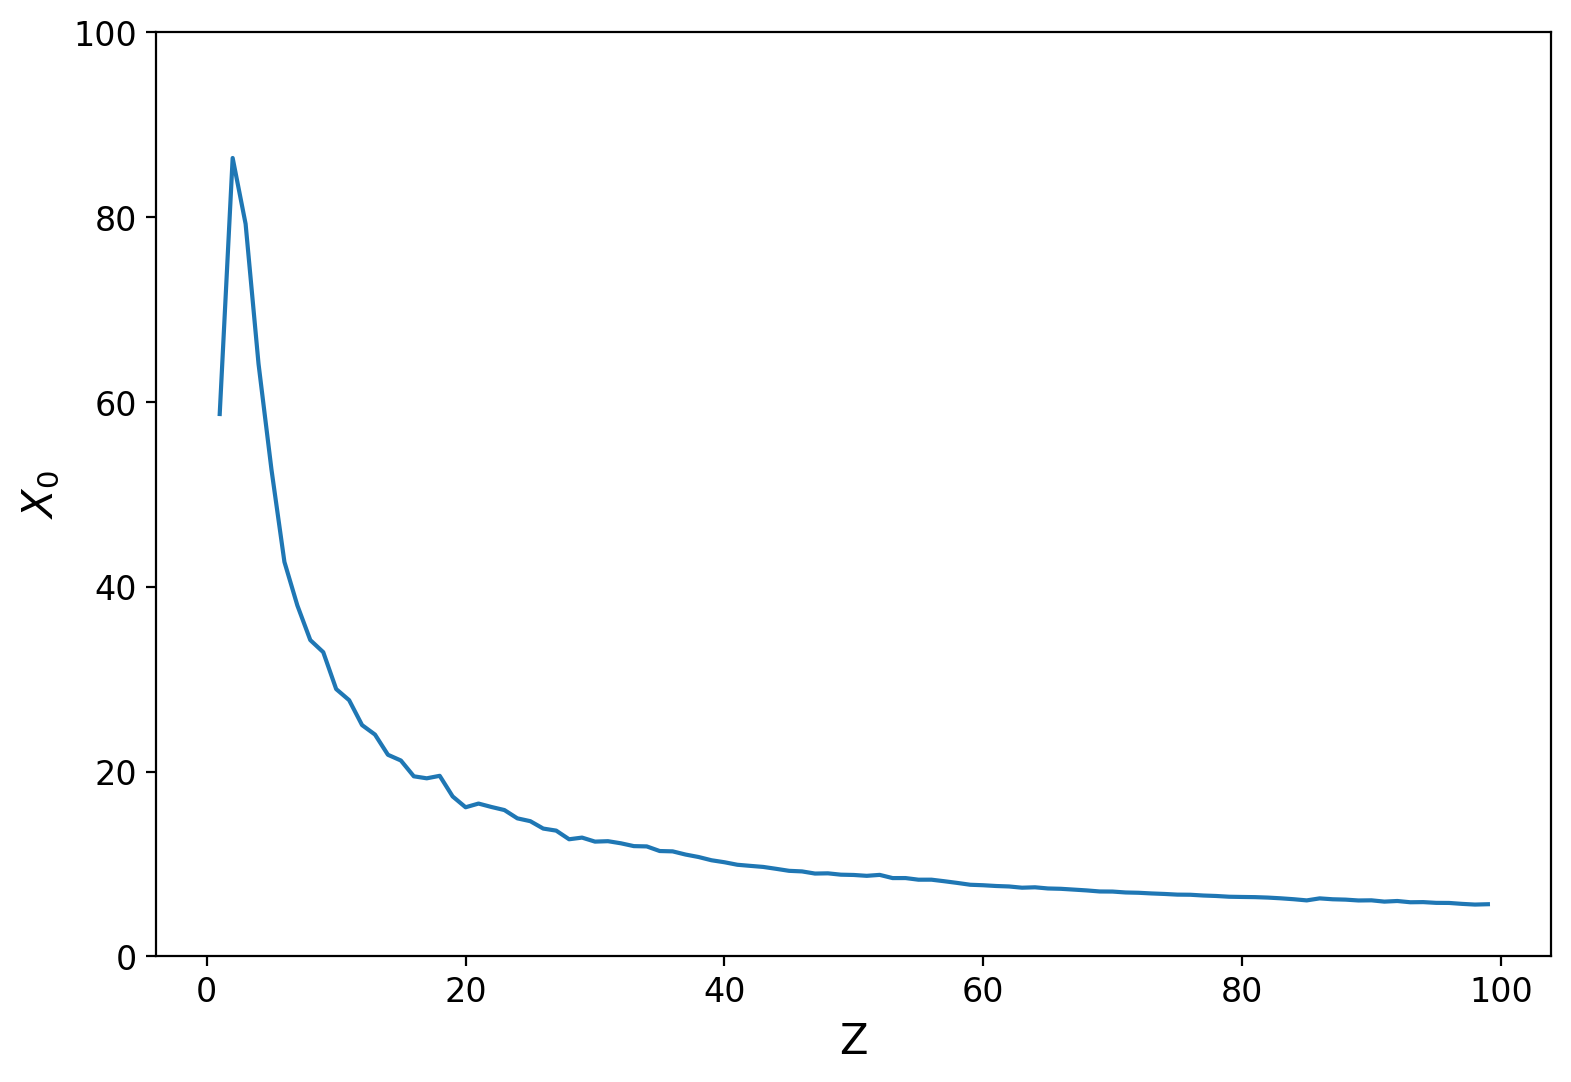

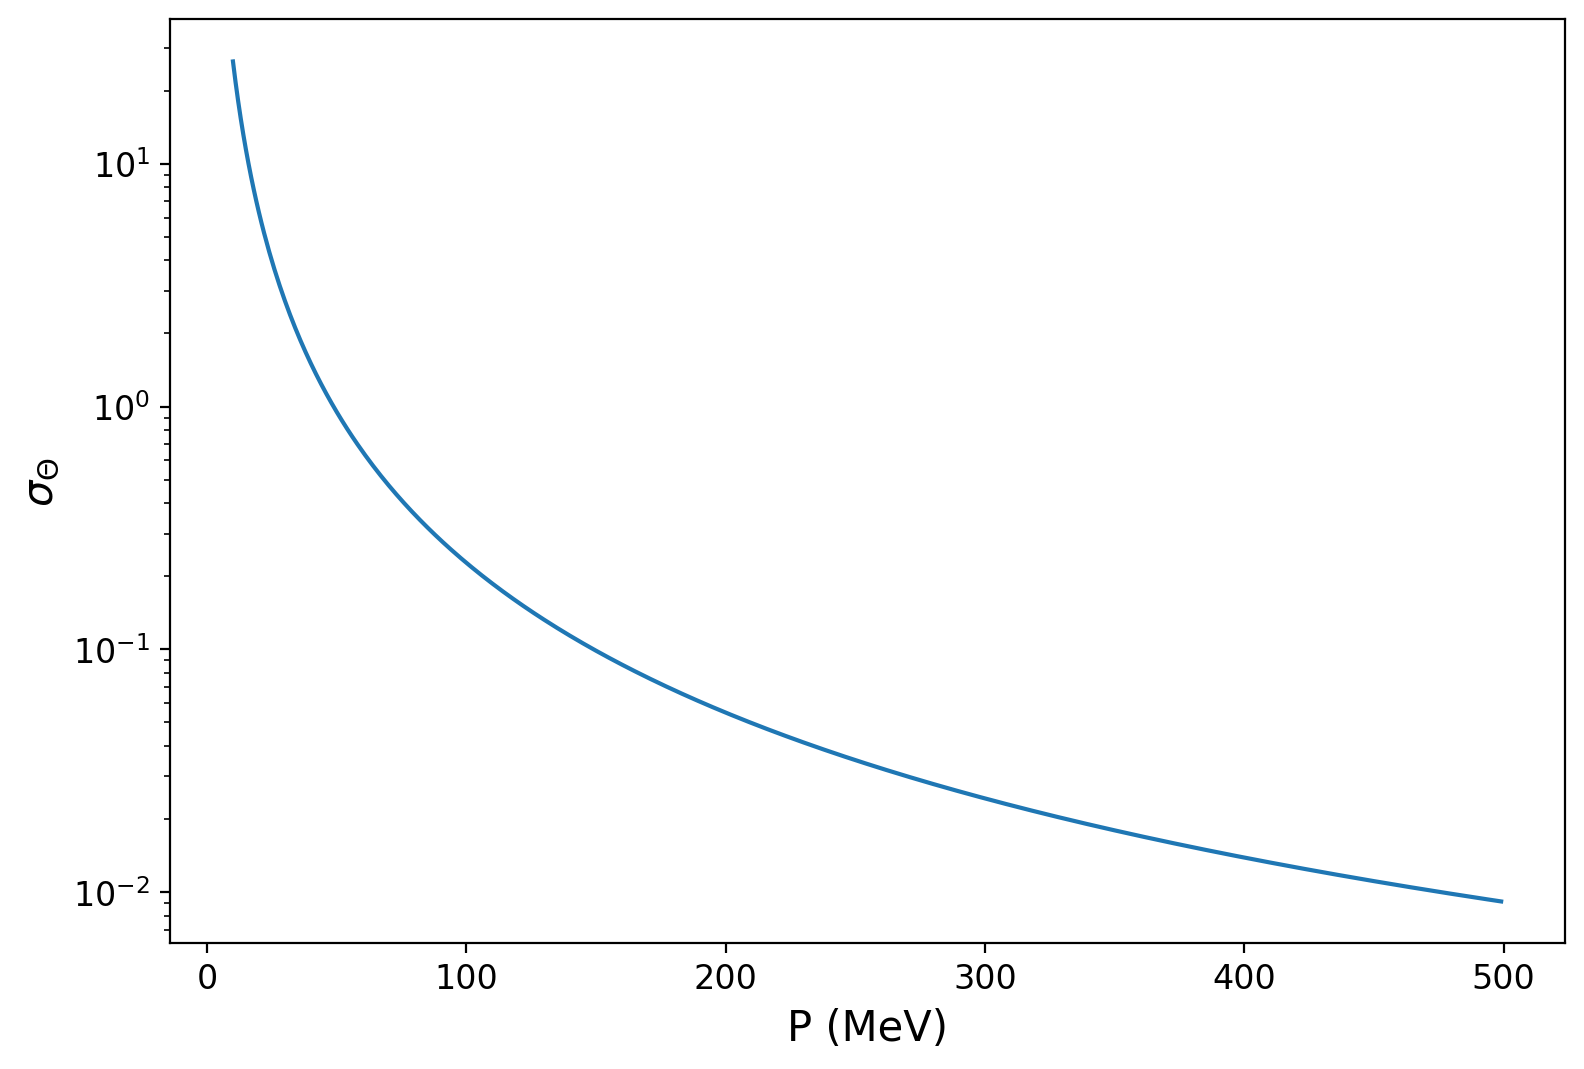

In [85]:
def X0(iZ):
    const=(716.408**-1)/A(iZ)
    a = iZ/137.
    Lrad =np.log(184.15*iZ**(-1./3.))
    Lradp=np.log(1194*iZ**(-2./3.))
    fZ = a**2*((1+a**2)**(-1)+0.20206-0.0369*a**2+0.0083*a**4-0.002*a**6)
    val=const*(iZ**2*(Lrad-fZ)+iZ*Lradp)
    return 1./val

def sigmaTheta(ip,im,iX0,idx=1.0,zpart=1):
    C=13.6
    X0=iX0
    dx=idx/iX0
    const=C/(beta(ip,im)*ip)*zpart*np.sqrt(dx)
    logterm=1+0.038*np.log(dx*zpart**2/beta(ip,im)**2)
    return const*logterm

def thetaScatter(ip,im,iX0,idx,zpart=1):
    z1=np.random.normal(0,1,ip.shape[0])
    z2=np.random.normal(0,1,ip.shape[0])
    stheta=sigmaTheta(ip,im,iX0,zpart)
    dy    =z1*idx*stheta/np.sqrt(12.) + z2*idx*stheta/2
    dtheta=z2*stheta
    return dtheta,dy

lZ=np.arange(1,100,1)
lX0=np.zeros(len(lZ))
for pZ in lZ:
    lX0[pZ-1] = X0(pZ)
print(X0(82))
plt.plot(lZ,lX0)
plt.xlabel("Z")
plt.ylabel("$X_{0}$")
plt.ylim(0,100)
plt.show()

lP=np.arange(10,500,1)
lST = sigmaTheta(lP,mproton,X0(8))
plt.plot(lP,lST)
plt.yscale('log')
plt.xlabel('P (MeV)')
plt.ylabel('$\sigma_{\Theta}$')
plt.show()

What we see above is that for very low energy we have very large angles when we get to the low momenta. Basically, the proton can go anywhere, this can blur out our beam, and if we are using this for cancer therapy can cause more damage.

One important thing to consider is that we need to make sure our angular scatter is physical, that means we should make sure that our angles are ok.

Scanning: 150
Scanning: 200
Scanning: 250
Scanning: 300


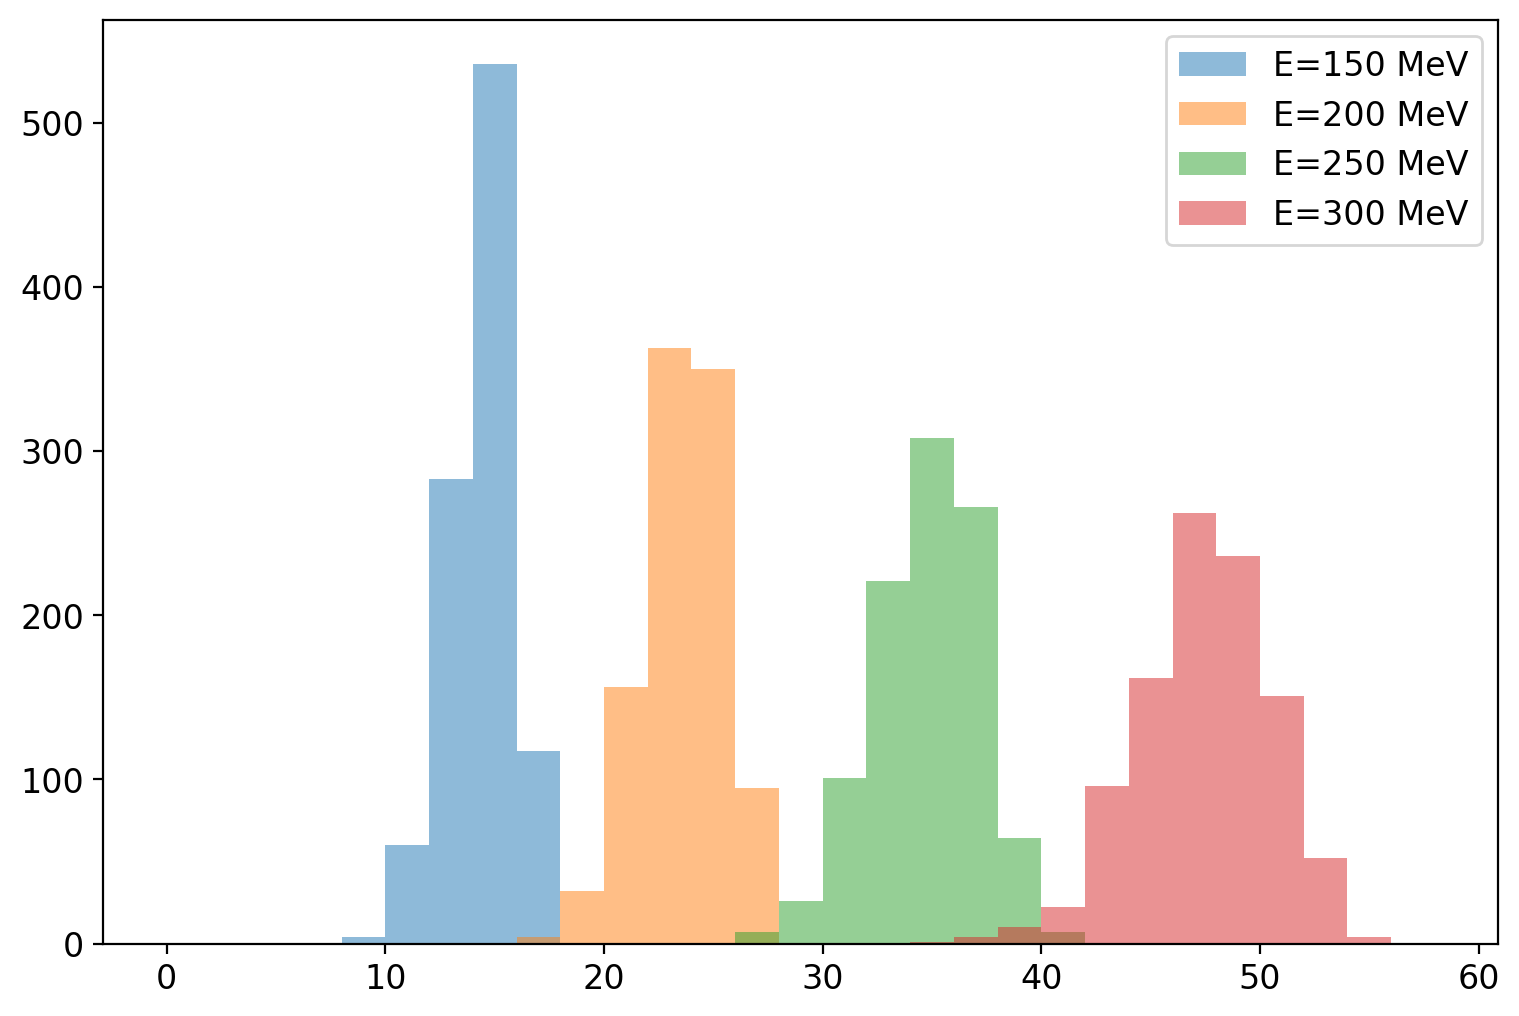

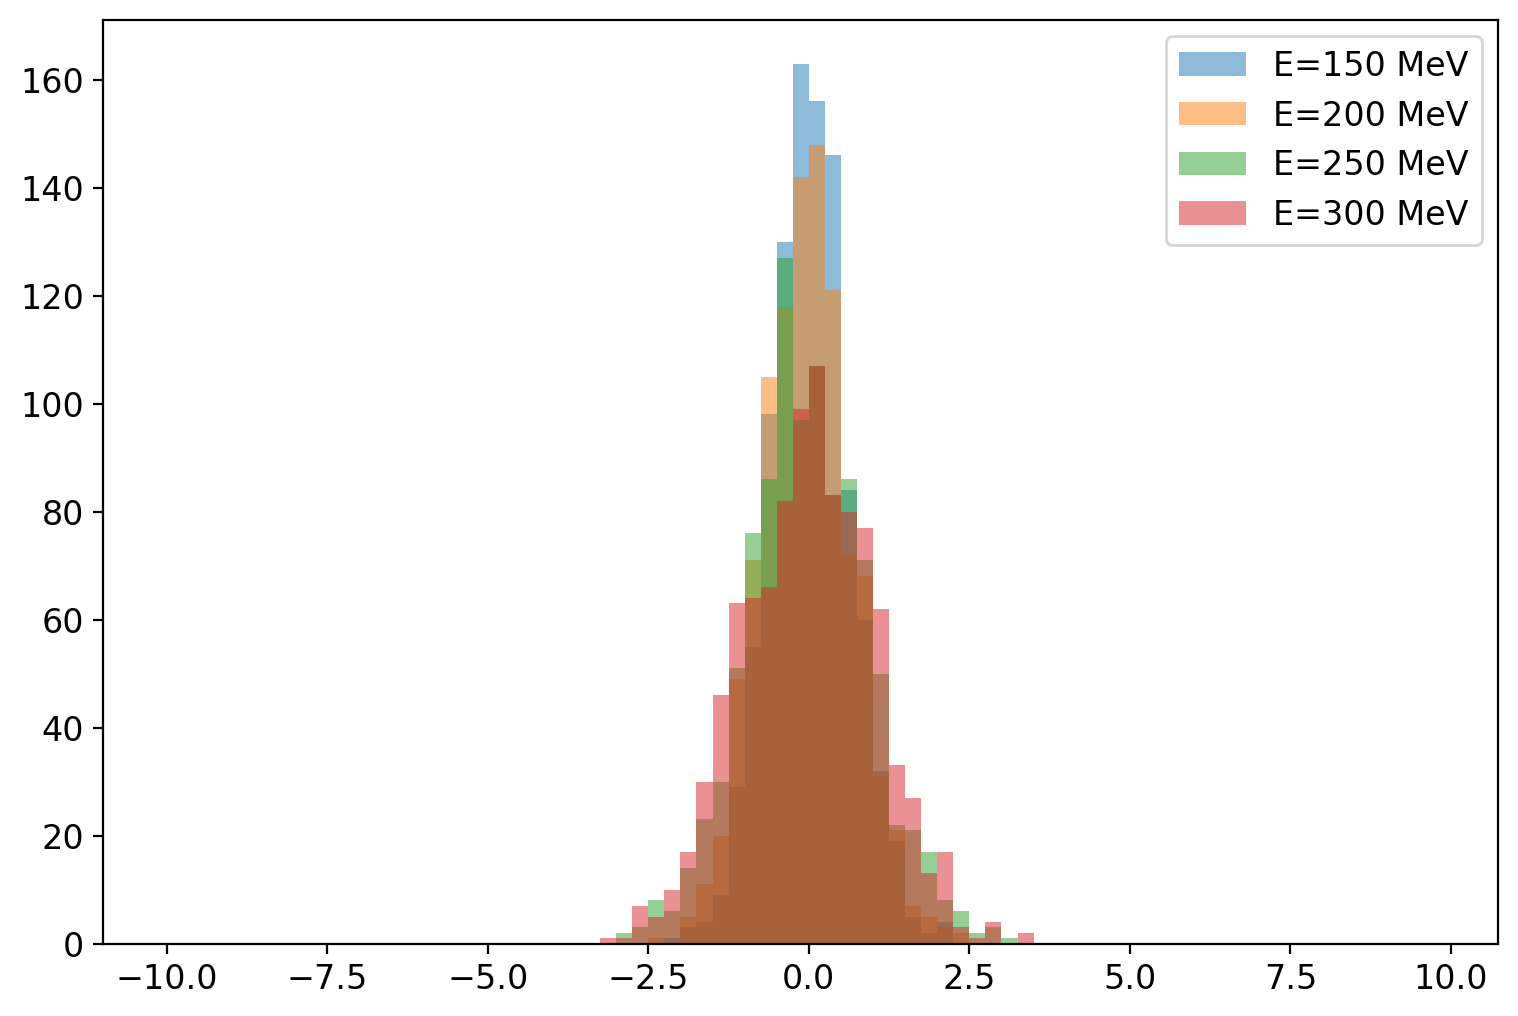

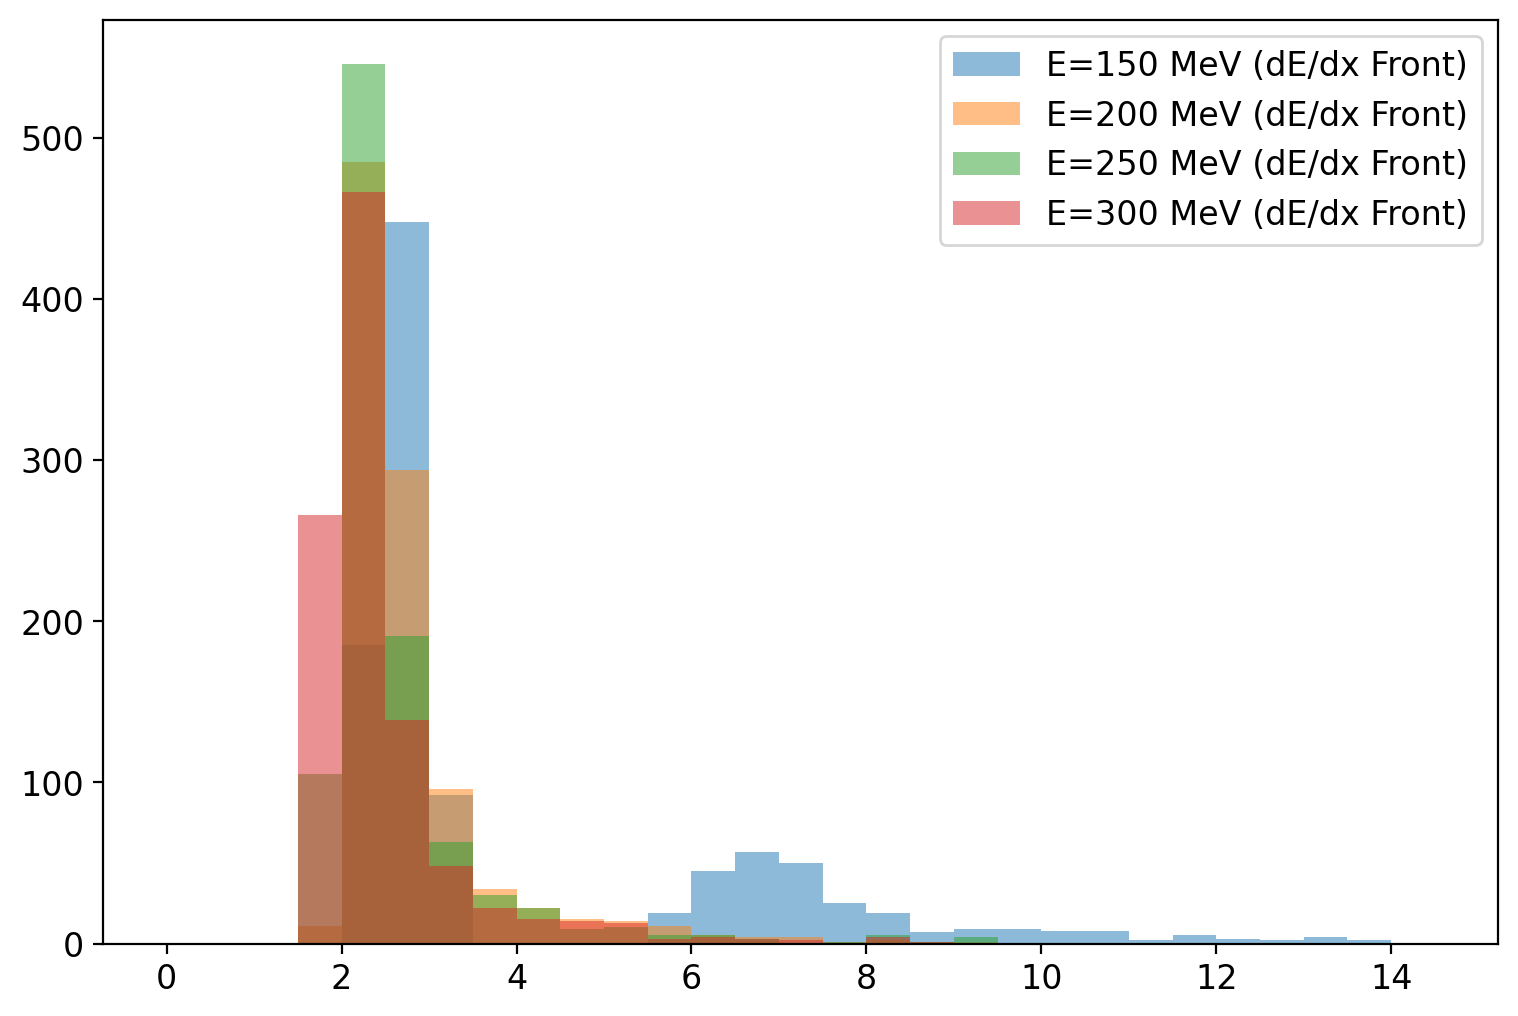

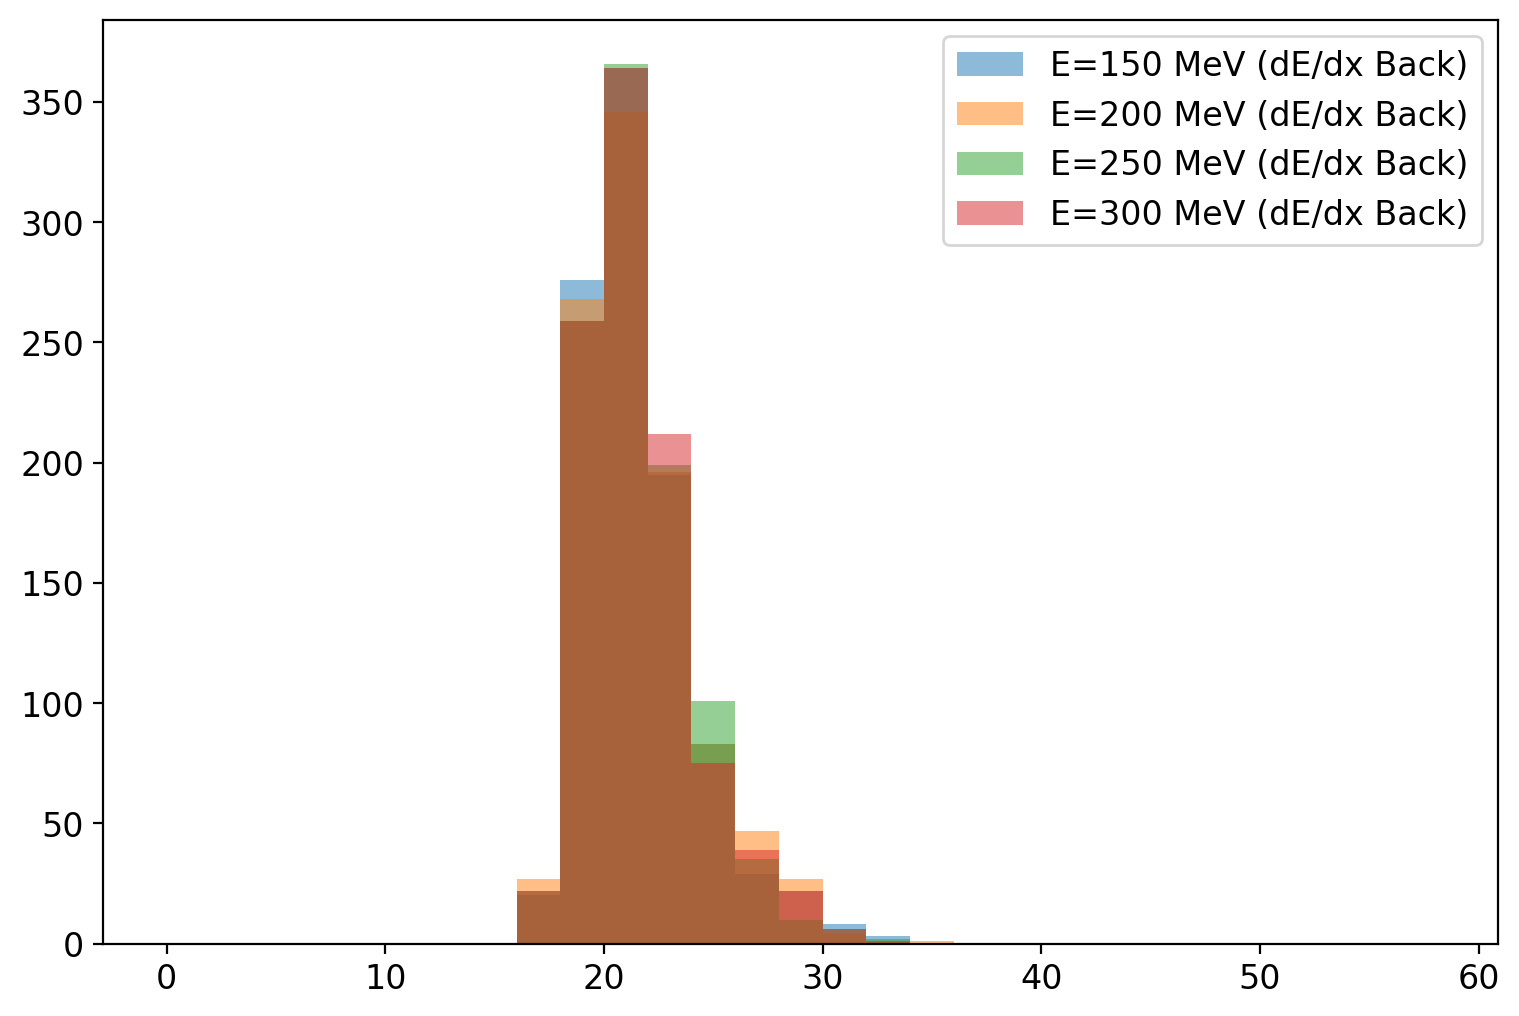

In [86]:
def simNYParallelSample(iN, ie=500,im=935,idt=1e-10,iZ=8):
    xstep  = np.empty((0,iN))
    ystep  = np.empty((0,iN))
    estep  = np.empty((0,iN))
    pstep  = np.empty((0,iN))
    theta=0
    y=0
    c=3e10
    dist=np.zeros(iN)
    e=np.ones(iN)*ie
    lX0 = X0(iZ)
    print("Scanning:",ie)
    while np.any(e > 5):
        p = eToP(e,im)
        lMPV,lWMPV  = landauMPV(p,im,iZ=iZ,irho=1.06)
        dE = np.zeros(lMPV.shape)
        ##Here we have to parallelize by hand, this is not good
        for i0, (pMPV,pWMPV) in enumerate(zip(lMPV,lWMPV)):
            dE[i0]     = landau.sample(pMPV, pWMPV,1)
        dx     = beta(p,im)*c*idt#speed of light
        dTheta,dy = thetaScatter(p,im,lX0,idx=dx,zpart=1)
        pdEdX  = np.minimum(dE*dx,e-0.1)
        e      -= pdEdX
        dist   += dx*np.cos(theta)
        y      += dy + np.sin(theta)*dx
        theta  += dTheta
        xstep  = np.vstack((xstep,dist))
        ystep  = np.vstack((ystep,y))
        estep  = np.vstack((estep,pdEdX))
        pstep  = np.vstack((pstep,e))
    xstep = xstep.T
    estep = estep.T
    pstep = pstep.T
    ystep = ystep.T
    return xstep,pstep,estep,ystep

xstep150,pstep150,estep150,ystep150=simNYParallelSample(ie=150,im=mproton,iN=1000,idt=1e-10,iZ=8)
xstep200,pstep200,estep200,ystep200=simNYParallelSample(ie=200,im=mproton,iN=1000,idt=1e-10,iZ=8)
xstep250,pstep250,estep250,ystep250=simNYParallelSample(ie=250,im=mproton,iN=1000,idt=1e-10,iZ=8)
xstep300,pstep300,estep300,ystep300=simNYParallelSample(ie=300,im=mproton,iN=1000,idt=1e-10,iZ=8)

xrange=np.arange(0,60,2)
plt.hist(xstep150[:,-1],bins=xrange,alpha=0.5,label='E=150 MeV')
plt.hist(xstep200[:,-1],bins=xrange,alpha=0.5,label='E=200 MeV')
plt.hist(xstep250[:,-1],bins=xrange,alpha=0.5,label='E=250 MeV')
plt.hist(xstep300[:,-1],bins=xrange,alpha=0.5,label='E=300 MeV')
plt.legend()
plt.show()

xrange=np.arange(-10,10,0.25)
plt.hist(ystep150[:,-1],bins=xrange,alpha=0.5,label='E=150 MeV')
plt.hist(ystep200[:,-1],bins=xrange,alpha=0.5,label='E=200 MeV')
plt.hist(ystep250[:,-1],bins=xrange,alpha=0.5,label='E=250 MeV')
plt.hist(ystep300[:,-1],bins=xrange,alpha=0.5,label='E=300 MeV')
plt.legend()
plt.show()

ef150,eb150=sumEstep(estep150,xstep150)
ef200,eb200=sumEstep(estep200,xstep200)
ef250,eb250=sumEstep(estep250,xstep250)
ef300,eb300=sumEstep(estep300,xstep300)

xrange=np.arange(0,15,0.5)
plt.hist(ef150,bins=xrange,alpha=0.5,label='E=150 MeV (dE/dx Front)')
plt.hist(ef200,bins=xrange,alpha=0.5,label='E=200 MeV (dE/dx Front)')
plt.hist(ef250,bins=xrange,alpha=0.5,label='E=250 MeV (dE/dx Front)')
plt.hist(ef300,bins=xrange,alpha=0.5,label='E=300 MeV (dE/dx Front)')
plt.legend()
plt.show()

xrange=np.arange(0,60,2)
plt.hist(eb150,bins=xrange,alpha=0.5,label='E=150 MeV (dE/dx Back)')
plt.hist(eb200,bins=xrange,alpha=0.5,label='E=200 MeV (dE/dx Back)')
plt.hist(eb250,bins=xrange,alpha=0.5,label='E=250 MeV (dE/dx Back)')
plt.hist(eb300,bins=xrange,alpha=0.5,label='E=300 MeV (dE/dx Back)')
plt.legend()
plt.show()


## Constructing a likelihood

Now this is where things become really interesting. The simulation we made above models a very specific process, and the more and more elements of realism. However, this gets more complicated. That being said, we see in the end the distributions we model are fairly reasonable.

What we can do after the fact is try to fit the result of the simulation and construct a parameteric model. A paramettric model for the behavior of what is going, this is often how we try to characterize things.


A: 15000 15000 15000


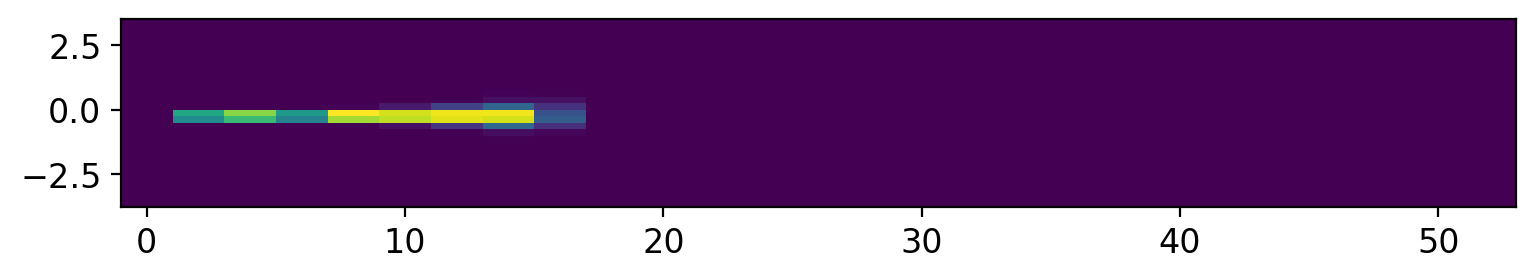

A: 21000 21000 21000


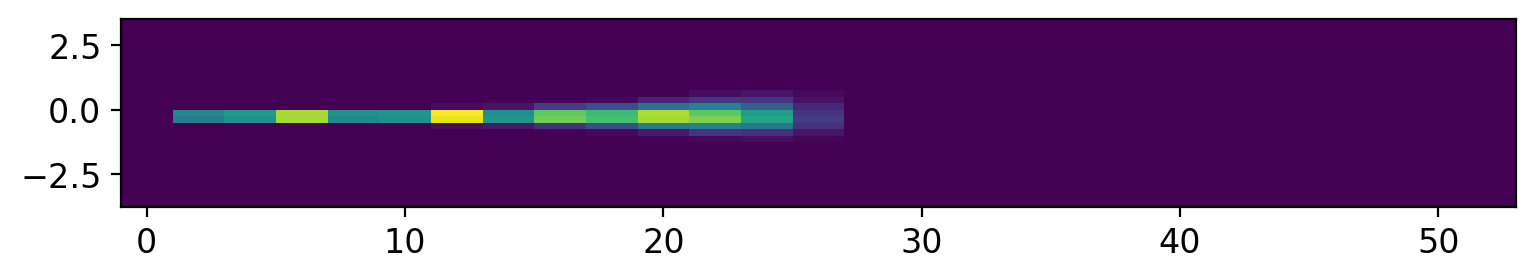

A: 29000 29000 29000


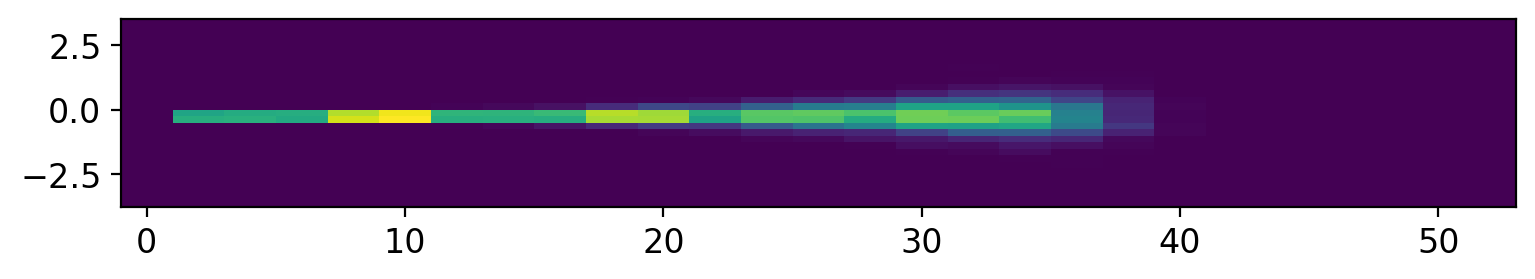

A: 36000 36000 36000


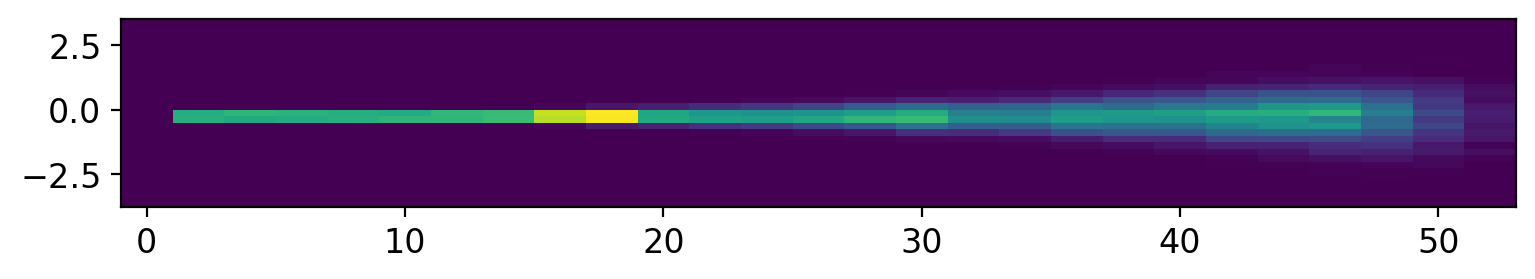

In [87]:
def plotImage(iId,ixstep,iestep,iystep):
    #plt.plot(ixstep[iId],iystep[iId])#,iestep[iId])
    #plt.show()
    #Now lets make a regular image
    xbin = np.arange(-1,55, 2)
    ybin = np.arange(-3.75, 3.75, 0.25)
    #xbin = np.arange(-0.5,60.5, 1)
    #ybin = np.arange(-5.125, 5.125, 0.25)
    print("A:",len(ixstep.flatten()),len(iystep.flatten()),len(iestep.flatten()))
    H, xedges, yedges = np.histogram2d(ixstep.flatten(), iystep.flatten(), bins=(xbin, ybin),weights=iestep.flatten())
    plt.imshow(H.T,extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
    plt.show()
    #X, Y = np.meshgrid(xedges, yedges)
    #plt.pcolormesh(X,Y,H.T)
    #plt.show()

plotImage(-1,xstep150,estep150,ystep150)
plotImage(-1,xstep200,estep200,ystep200)
plotImage(-1,xstep250,estep250,ystep250)
plotImage(-1,xstep300,estep300,ystep300)

<a name='exercises_21_5'></a>     

| [Top](#section_21_0) | [Restart Section](#section_21_5) | [Next Section](#section_21_6) |


### <span style="border:3px; border-style:solid; padding: 0.15em; border-color: #90409C; color: #90409C;">Ex-21.5.1</span>

<br>